# Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from imageio import imread

import re, nltk
nltk.download('stopwords') # you can run this in terminal
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from functools import lru_cache # for caching lemmatization results to help save time

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# Turn off warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\yapcm\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\yapcm\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Loading the Data

In [2]:
df = pd.read_csv('./uncommitted/Hotel_Reviews.csv')
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


Since we have duplicates hotel details from different reviewers who stayed at the same hotel, let's make a hotels dataset out of the original dataset so we can investigate each hotel later.

In [3]:
df_hotels = df[['Hotel_Address', 'Additional_Number_of_Scoring', 'Average_Score', 'Hotel_Name', 'Total_Number_of_Reviews', 'lat', 'lng']].drop_duplicates()
df_hotels.head()

,Hotel_Address,Additional_Number_of_Scoring,Average_Score,Hotel_Name,Total_Number_of_Reviews,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7.7,Hotel Arena,1403,52.360576,4.915968
405,1 15 Templeton Place Earl s Court Kensington a...,244,8.5,K K Hotel George,1831,51.491888,-0.194971
971,1 2 Serjeant s Inn Fleet Street City of London...,639,9.2,Apex Temple Court Hotel,2619,51.513734,-0.108751
2008,1 3 Queens Garden Westminster Borough London W...,1058,7.7,The Park Grand London Paddington,4380,51.514218,-0.180903
3778,1 3 Rue d Argentine 16th arr 75116 Paris France,26,8.4,Monhotel Lounge SPA,171,48.874348,2.289733


In [4]:
df_hotels.shape

(1494, 7)

Now let's go back to the original dataset and explore around

In [5]:
df.shape

(515738, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

We can see that the dataset for the most part does not contain missing values except for latitude and longitude values.

In [7]:
df.describe(include='all')

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
count,515738,515738.000000,515738,515738.000000,515738,515738,515738,515738.000000,515738.000000,515738,515738.000000,515738.000000,515738.000000,515738,515738,512470.000000,512470.000000
unique,1493,NaN,731,NaN,1492,227,330011,NaN,NaN,412601,NaN,NaN,NaN,55242,731,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN
freq,4789,NaN,2585,NaN,4789,245246,127890,NaN,NaN,35946,NaN,NaN,NaN,5101,2585,NaN,NaN
mean,NaN,498.081836,NaN,8.397487,NaN,NaN,NaN,18.539450,2743.743944,NaN,17.776458,7.166001,8.395077,NaN,NaN,49.442439,2.823803
std,NaN,500.538467,NaN,0.548048,NaN,NaN,NaN,29.690831,2317.464868,NaN,21.804185,11.040228,1.637856,NaN,NaN,3.466325,4.579425
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.000000,2.500000,NaN,NaN,41.328376,-0.369758
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.000000,7.500000,NaN,NaN,48.214662,-0.143372
50%,NaN,341.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.000000,8.800000,NaN,NaN,51.499981,0.010607
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.000000,9.600000,NaN,NaN,51.516288,4.834443


We can observe a number of things:
- Britannia International Hotel Canary Wharf is the most frequent hotel in this dataset
- The mean of all hotels average scores is 8.4, and the interquartile range (i.e. between 25th and 75th percentiles) is 8.1-8.8
- The mean of all individual review scores is also 8.4 but the interquartile range is 7.5-9.6
- The most frequent nationality of reviewer is United Kingdom

# Preprocessing and EDA

**Trip type and Traveller type distribution**

Add encoding columns for reviews that has the corresponding tags.

In [8]:
# Create columns for encoding trip type
df['triptype_Leisure'] = df['Tags'].map(lambda x: 1 if ' Leisure trip ' in x else 0)
df['triptype_Business'] = df['Tags'].map(lambda x: 1 if ' Business trip ' in x else 0)

In [9]:
# Create columns for encoding traveller type
df['travellertype_Couple'] = df['Tags'].map(lambda x: 1 if ' Couple ' in x else 0)
df['travellertype_With_a_pet'] = df['Tags'].map(lambda x: 1 if ' With a pet ' in x else 0)
df['travellertype_Solo_traveler'] = df['Tags'].map(lambda x: 1 if ' Solo traveler ' in x else 0)
df['travellertype_Group'] = df['Tags'].map(lambda x: 1 if ' Group ' in x else 0)
df['travellertype_Family_with_young_children'] = df['Tags'].map(lambda x: 1 if ' Family with young children ' in x else 0)
df['travellertype_Family_with_older_children'] = df['Tags'].map(lambda x: 1 if ' Family with older children ' in x else 0)
df['travellertype_Travelers_with_friends'] = df['Tags'].map(lambda x: 1 if ' Travelers with friends ' in x else 0)
df[100:105]

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,lng,triptype_Leisure,triptype_Business,travellertype_Couple,travellertype_With_a_pet,travellertype_Solo_traveler,travellertype_Group,travellertype_Family_with_young_children,travellertype_Family_with_older_children,travellertype_Travelers_with_friends
100,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,9/18/2016,7.7,Hotel Arena,United Kingdom,Building work starting at 7am waking us up no...,40,1403,Location,...,4.915968,1,0,0,0,0,1,0,0,0
101,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,9/12/2016,7.7,Hotel Arena,United Kingdom,Hotel is having some construction work done t...,56,1403,Location was ok and has access to all the pub...,...,4.915968,0,1,0,0,1,0,0,0,0
102,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,9/9/2016,7.7,Hotel Arena,Netherlands,There was a girl working in the restaurant an...,78,1403,The bed was amazing Actually our whole room l...,...,4.915968,1,0,1,0,0,0,0,0,0
103,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/31/2016,7.7,Hotel Arena,Australia,it s a shame about all the construction going...,27,1403,super comfy beds cozy rooms lovely staff pret...,...,4.915968,1,0,0,0,0,1,0,0,0
104,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/13/2016,7.7,Hotel Arena,United Kingdom,Building work is being done but it doesn t ca...,14,1403,Staff were brilliant Really helpful attentive...,...,4.915968,1,0,0,0,0,1,0,0,0


Let's visualise the distributions of trip type and traveller type.

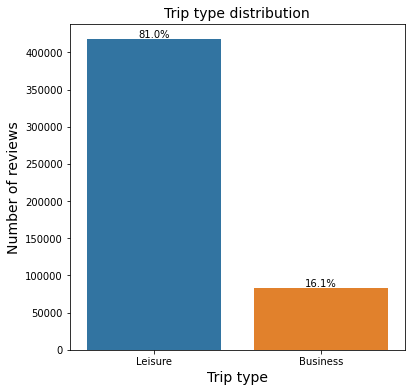

In [10]:
# Plot traveller type distribution
plt.figure(figsize=(6,6))
chart = sns.barplot(['Leisure', 'Business'],
            [df['triptype_Leisure'].sum(), df['triptype_Business'].sum()])
plt.title('Trip type distribution', fontsize=14)
plt.xlabel('Trip type', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
labels = [f'{round(v.get_height()/len(df)*100,1)}%' for v in chart.containers[0]]
chart.bar_label(chart.containers[0], labels=labels)
plt.show()

Most of the trips are for leisure compared to for business.

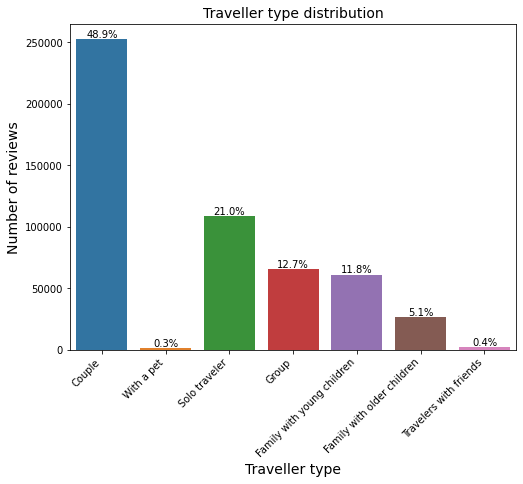

In [11]:
# Plot trip type distribution
travellertype_list = ['travellertype_Couple','travellertype_With_a_pet','travellertype_Solo_traveler','travellertype_Group','travellertype_Family_with_young_children','travellertype_Family_with_older_children','travellertype_Travelers_with_friends']
plt.figure(figsize=(8,6))
chart = sns.barplot(['Couple', 'With a pet', 'Solo traveler', 'Group', 'Family with young children', 'Family with older children', 'Travelers with friends'],
            df[travellertype_list].sum())
plt.title('Traveller type distribution', fontsize=14)
plt.xlabel('Traveller type', fontsize=14)
plt.ylabel('Number of reviews', fontsize=14)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
labels = [f'{round(v.get_height()/len(df)*100,1)}%' for v in chart.containers[0]]
chart.bar_label(chart.containers[0], labels=labels)
plt.show()

We see that couples make up the highest proportion of all reviews and there are only very few traveller(s) who bring pet, likely because hotels do not permit pets into rooms or it might be the inconvenience of bringing pets around when travelling.

**Hotel country distribution and Reviewers' Nationality**

Assign country to each row in both the reviews dataset and hotels dataset. We will investigate trends according to country of hotels.

In [12]:
country = df['Hotel_Address'].map(lambda x: x.split()[-1])
country = country.map(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df['hotel_country'] = country

country = df_hotels['Hotel_Address'].map(lambda x: x.split()[-1])
country = country.map(lambda x: 'United Kingdom' if x == 'Kingdom' else x)
df_hotels['hotel_country'] = country

In [13]:
df['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

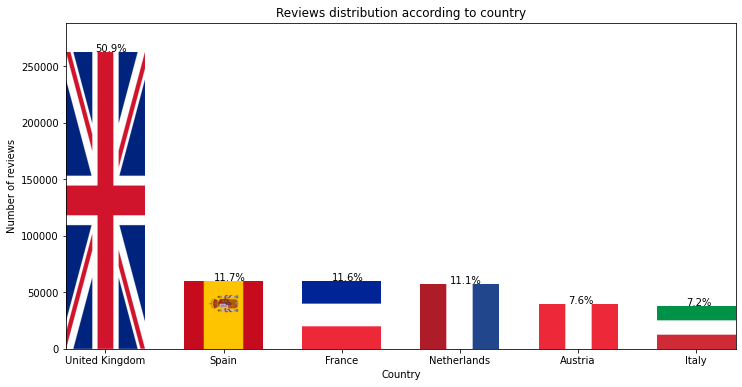

In [14]:
# Plot hotels distribution according to country
def image_plot(heights, images, spacing=0):
    # Iterate through images and data
    plt.figure(figsize=(12,6))
    xticks_pos = []
    for i, (height, img) in enumerate(zip(heights, images)):
        width = img.shape[0] *20
        left = width*i + spacing*i
        right = left + width
        plt.imshow(img, extent=[left, right, 0, height], aspect='auto')
        xticks_pos.append(left+10000) # for xticks position for country labels
        # Show percentage on top of bars
        percentage = height / len(df) * 100
        plt.text(left+7500, height+750, f"{round(percentage,1)}%")
    # Set x,y limits on plot window
    plt.xlim(0, right)
    plt.ylim(0, max(heights)*1.1)
    # Set xticks to country names, and set x, y labels and title
    plt.xticks(xticks_pos, df['hotel_country'].value_counts().index)
    plt.xlabel('Country')
    plt.ylabel('Number of reviews')
    plt.title('Reviews distribution according to country')

# Read in flag images
austria_flag = imread('austria-flag-medium.png').swapaxes(0, 1)
france_flag = imread('france-flag-medium.png').swapaxes(0, 1)
italy_flag = imread('italy-flag-medium.png').swapaxes(0, 1)
netherlands_flag = imread('netherlands-flag-medium.png').swapaxes(0, 1)
spain_flag = imread('spain-flag-medium.png').swapaxes(0, 1)
uk_flag = imread('united-kingdom-flag-medium.png').swapaxes(0, 1)

# Plot using image_plot
data = df['hotel_country'].value_counts()
flags = [uk_flag, spain_flag, france_flag, netherlands_flag, austria_flag, italy_flag]

image_plot(data, flags, spacing=10000)

The most number of reviews is from the United Kingdom, and the least number of reviews is from Italy. However, the next cell shows that most hotels in the dataset are located in France despite having low percentage of reviews.

In [15]:
unique_hotels_country_count = df_hotels['hotel_country'].value_counts()
unique_hotels_country_count

France            458
United Kingdom    400
Spain             211
Italy             162
Austria           158
Netherlands       105
Name: hotel_country, dtype: int64

In [16]:
# Mean of individual reviewer scores by country of hotels
df_mean = df.groupby(['hotel_country']).mean()
df_mean['Reviewer_Score'].sort_values(ascending=False)

hotel_country
Spain             8.554092
Austria           8.545047
Netherlands       8.456311
France            8.420081
Italy             8.346722
United Kingdom    8.324138
Name: Reviewer_Score, dtype: float64

In [17]:
# Mean of hotels average scores by country of hotels
df_hotels_mean = df_hotels.groupby(['hotel_country']).mean()
df_hotels_mean['Average_Score'].sort_values(ascending=False)

hotel_country
Austria           8.550000
Spain             8.496209
France            8.493668
United Kingdom    8.464000
Netherlands       8.409524
Italy             8.318519
Name: Average_Score, dtype: float64

The mean of scores for each country is slight different using whether the individual reviewer scores or the hotels' average scores, nevertheless there is not a strong link between country and score.

Let's look at trends according to the nationality of reviewers.

In [18]:
# Reviewers' nationality
nationality_count = df['Reviewer_Nationality'].value_counts()
nationality_count

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Cape Verde                        1
 Anguilla                          1
 Vatican City                      1
 Northern Mariana Islands          1
 Guinea                            1
Name: Reviewer_Nationality, Length: 227, dtype: int64

<ipython-input-19-c1488a952e27>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')
<ipython-input-19-c1488a952e27>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(nationality_count.index[-10:], rotation=45, ha='right')


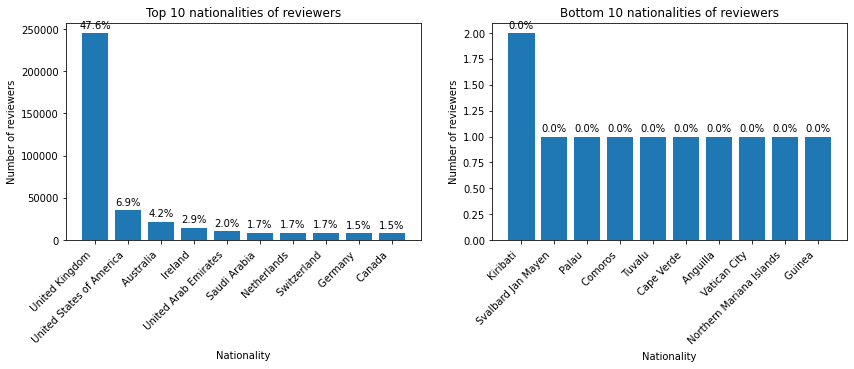

In [19]:
# Plot bar plots of top 10 nationalities and bottom 10 nationalities in the number of reviewers
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
rects1 = ax[0].bar(nationality_count.index[:10], nationality_count[:10])
ax[0].set_title('Top 10 nationalities of reviewers')
ax[0].set_xlabel('Nationality')
ax[0].set_ylabel('Number of reviewers')
_ = ax[0].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')

rects2 = ax[1].bar(nationality_count.index[-10:], nationality_count[-10:])
ax[1].set_title('Bottom 10 nationalities of reviewers')
ax[1].set_xlabel('Nationality')
ax[1].set_ylabel('Number of reviewers')
_ = ax[1].set_xticklabels(nationality_count.index[-10:], rotation=45, ha='right')

def autolabel(rects, ax_i):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        # print(rect)
        height = rect.get_height()
        ax[ax_i].annotate(f"{round(height/len(df)*100, 1)}%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, 0)
autolabel(rects2, 1)

In [20]:
# Average scores according to reviewers' nationalities
nationality_score = df.groupby(['Reviewer_Nationality']).mean()
nationality_score = nationality_score['Reviewer_Score'].sort_values(ascending=False)
nationality_score

Reviewer_Nationality
 Equatorial Guinea            10.00
 Crimea                       10.00
 Svalbard Jan Mayen           10.00
 Comoros                      10.00
 Cape Verde                    9.60
                              ...  
 Nepal                         6.84
 Mali                          6.44
 Northern Mariana Islands      5.80
 American Samoa                5.65
 Montserrat                    5.40
Name: Reviewer_Score, Length: 227, dtype: float64

In [21]:
score_top_10_nationalities_in_no_reviewers = nationality_score[nationality_count.index[:10]]
score_top_10_nationalities_in_no_reviewers

 United Kingdom               8.486352
 United States of America     8.786999
 Australia                    8.591718
 Ireland                      8.464052
 United Arab Emirates         7.878828
 Saudi Arabia                 7.881767
 Netherlands                  8.125148
 Switzerland                  8.161593
 Germany                      8.132477
 Canada                       8.547783
Name: Reviewer_Score, dtype: float64

<ipython-input-22-4c41aac657aa>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(nationality_score.index[:10], rotation=45, ha='right')
<ipython-input-22-4c41aac657aa>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(nationality_score.index[-10:], rotation=45, ha='right')
<ipython-input-22-4c41aac657aa>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[2].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')


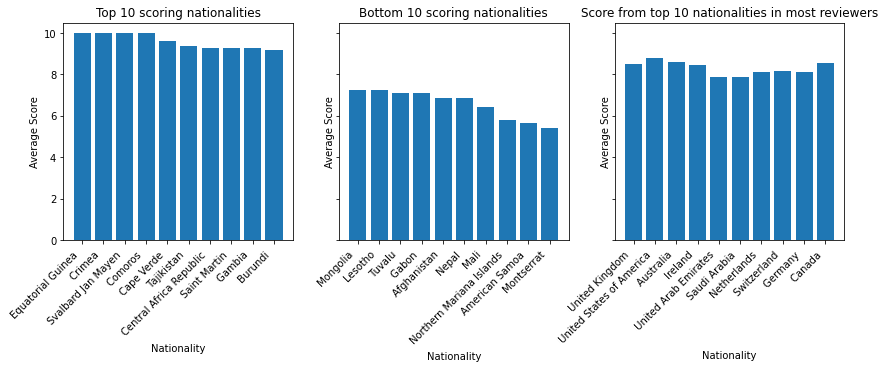

In [22]:
# Plot bar plots of top 10 nationalities and bottom 10 nationalities in the average reviewers score
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,4), sharey=True)
rects1 = ax[0].bar(nationality_score.index[:10], nationality_score[:10])
ax[0].set_title('Top 10 scoring nationalities')
ax[0].set_xlabel('Nationality')
ax[0].set_ylabel('Average Score')
_ = ax[0].set_xticklabels(nationality_score.index[:10], rotation=45, ha='right')

rects2 = ax[1].bar(nationality_score.index[-10:], nationality_score[-10:])
ax[1].set_title('Bottom 10 scoring nationalities')
ax[1].set_xlabel('Nationality')
ax[1].set_ylabel('Average Score')
_ = ax[1].set_xticklabels(nationality_score.index[-10:], rotation=45, ha='right')

rects3 = ax[2].bar(nationality_count.index[:10], score_top_10_nationalities_in_no_reviewers)
ax[2].set_title('Score from top 10 nationalities in most reviewers')
ax[2].set_xlabel('Nationality')
ax[2].set_ylabel('Average Score')
_ = ax[2].set_xticklabels(nationality_count.index[:10], rotation=45, ha='right')

Bear in mind the nationalities in the top 10 and bottom 10 scoring bar charts are only one or two reviewers per nationality as they aren't major nationalities.

**Trends according to Month and Year**

Let's look at trends according to month when reviews were given.

In [23]:
# Average values by months
df['Month'] = df['Review_Date'].map(lambda x: x.split('/')[0])
df_month_mean = df.groupby(['Month']).mean()
df_month_mean

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,triptype_Leisure,triptype_Business,travellertype_Couple,travellertype_With_a_pet,travellertype_Solo_traveler,travellertype_Group,travellertype_Family_with_young_children,travellertype_Family_with_older_children,travellertype_Travelers_with_friends
Month,,,,,,,,,,,,,,,,,,
1,517.400014,8.413705,17.940737,2781.594956,17.946834,7.259614,8.485011,49.785925,2.703625,0.822472,0.147921,0.528173,0.004033,0.193068,0.106047,0.129012,0.040829,0.002871
10,486.546609,8.384458,18.074197,2703.293661,16.359943,7.338914,8.261577,49.348938,2.882521,0.777342,0.194877,0.498050,0.002691,0.231804,0.126063,0.104646,0.037132,0.002304
11,518.467000,8.382091,17.665999,2774.376619,16.248957,7.641674,8.338843,49.600102,2.653221,0.760217,0.212427,0.497137,0.003447,0.243453,0.127023,0.098554,0.031332,0.002502
12,524.050597,8.399048,17.324236,2777.136920,16.418638,7.657157,8.427132,49.842952,2.811204,0.810589,0.160754,0.507991,0.003711,0.210089,0.114828,0.127982,0.036812,0.002298
2,531.504092,8.399588,18.139041,2783.424681,17.385171,7.030545,8.528058,49.878712,2.346899,0.771228,0.195726,0.469533,0.002007,0.288715,0.107480,0.097733,0.033881,0.002658
3,519.662467,8.393320,18.258672,2781.925517,17.752615,7.080637,8.479832,49.674212,2.523488,0.767575,0.201776,0.483362,0.001605,0.227317,0.137825,0.110071,0.037606,0.003819
4,505.945480,8.408453,19.273815,2751.031434,18.901243,7.003754,8.431530,49.413573,2.758832,0.805284,0.165823,0.458480,0.002309,0.202015,0.129189,0.163072,0.043094,0.004151
5,491.524844,8.398608,19.525081,2718.667649,18.923962,7.109421,8.381041,49.363975,2.827431,0.811615,0.159561,0.494730,0.002194,0.202409,0.144870,0.118176,0.033362,0.006453
6,483.758626,8.398077,19.698900,2715.588260,19.271214,6.854415,8.391419,49.238394,2.894210,0.817442,0.154910,0.497366,0.002051,0.203119,0.154513,0.095533,0.041449,0.008019


Text(0.5, 1.0, 'Average score by month')

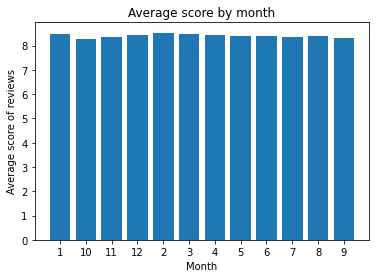

In [24]:
# Plot average score by month
plt.bar(df_month_mean.index, df_month_mean['Reviewer_Score'])
plt.xlabel('Month')
plt.ylabel('Average score of reviews')
plt.title('Average score by month')

And look at trends according to year.

In [25]:
# Average values by year
df['Year'] = df['Review_Date'].map(lambda x: x.split('/')[-1])
df_year_mean = df.groupby(['Year']).mean()
df_year_mean

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng,triptype_Leisure,triptype_Business,travellertype_Couple,travellertype_With_a_pet,travellertype_Solo_traveler,travellertype_Group,travellertype_Family_with_young_children,travellertype_Family_with_older_children,travellertype_Travelers_with_friends
Year,,,,,,,,,,,,,,,,,,
2015,491.271489,8.375398,16.686037,2713.769769,15.939044,7.867435,8.319843,49.338725,2.932284,0.802744,0.169920,0.505284,0.003057,0.218308,0.118834,0.068076,0.089498,0.000000
2016,506.008566,8.401862,18.282005,2778.004043,17.668831,7.175845,8.424700,49.470125,2.801208,0.813924,0.158081,0.504661,0.002969,0.207138,0.120014,0.097382,0.067042,0.003763
2017,488.821533,8.403426,20.090818,2704.045049,19.065564,6.726564,8.390479,49.458226,2.796566,0.807950,0.159941,0.453402,0.002111,0.211348,0.143022,0.183868,0.001039,0.007321


In [26]:
df_year_mean.index

Index(['2015', '2016', '2017'], dtype='object', name='Year')

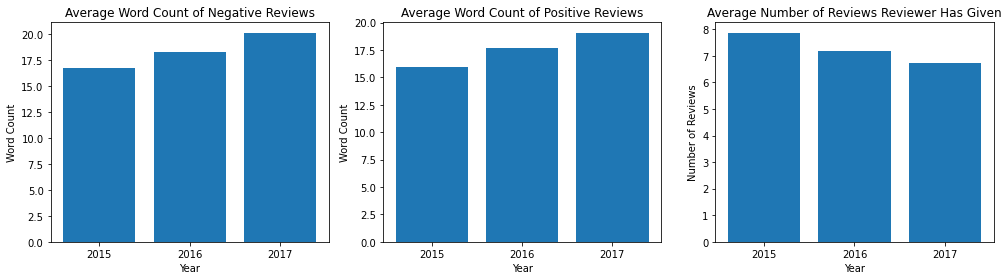

In [27]:
# Plot noticeable trends in terms of year
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
ax[0].bar(df_year_mean.index, df_year_mean['Review_Total_Negative_Word_Counts'])
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Word Count')
ax[0].set_title('Average Word Count of Negative Reviews')
ax[1].bar(df_year_mean.index, df_year_mean['Review_Total_Positive_Word_Counts'])
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Word Count')
ax[1].set_title('Average Word Count of Positive Reviews')
ax[2].bar(df_year_mean.index, df_year_mean['Total_Number_of_Reviews_Reviewer_Has_Given'])
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Number of Reviews')
ax[2].set_title('Average Number of Reviews Reviewer Has Given')
fig.tight_layout()

After looking at months and years, only noticeable difference in review score with respect to date is from year 2015 to 2017:
- both negative word counts and positive word counts are increasing
- total number of reviews reviewer has given is decreasing

# Sampling the Data

To speed up computation, we will sample a fraction of the original dataset.

In [28]:
df = df.sample(frac=0.2, replace = False, random_state=14)
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,travellertype_Couple,travellertype_With_a_pet,travellertype_Solo_traveler,travellertype_Group,travellertype_Family_with_young_children,travellertype_Family_with_older_children,travellertype_Travelers_with_friends,hotel_country,Month,Year
250306,8 rue Chambiges 8th arr 75008 Paris France,122,8/11/2015,8.9,Chambiges Elys es,United Kingdom,There were bed bugs Nasty,7,858,No Positive,...,1,0,0,0,0,0,0,France,8,2015
358387,Kirchberggasse 6 07 Neubau 1070 Vienna Austria,285,2/25/2017,8.7,K K Hotel Maria Theresia,United Kingdom,Walls are pretty thin so could hear folk in t...,17,3181,Room was very clean and the bed was extremely...,...,1,0,0,0,0,0,0,Austria,2,2017
351102,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,2/18/2017,8.3,Mercure Josefshof Wien,Switzerland,Room on the attic with window in the roof fel...,31,2526,Accessible to the metro and therefore easy ac...,...,0,0,1,0,0,0,0,Austria,2,2017
286546,Bergara 8 Eixample 08002 Barcelona Spain,256,9/27/2016,8.8,Hotel Pulitzer,Kuwait,not much entertainment in room we were only s...,31,1746,location was excellent staff were very helpfu...,...,1,0,0,0,0,0,0,Spain,9,2016
485631,Via Pietro Gaggia 3 Ripamonti Corvetto 20139 M...,269,7/17/2016,8.1,Starhotels Business Palace,United Arab Emirates,No swimming pool,5,5265,Location Room size Cleaneanse,...,0,0,0,0,1,0,0,Italy,7,2016


In [29]:
df.shape

(103148, 29)

# Natural Language Processing

We remove stop words and perform lemmatisation as well as replacing certain redundant comment on each negative review and positive review.

In [30]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
neg_reviews = []

# Function for lemmatization wrapped in lru_cache decorator for storing duplicate result in cache for faster computation
@lru_cache(maxsize=None) # Need to set maxsize=None otherwise it will default to 128
def perform_lemmatization(token):
    return lemmatizer.lemmatize(token)

# Perform NLP on all the negative reviews 
for review in df['Negative_Review']:
    review = review.lower()
    review = review.strip()
    if review in ['no negative', 'n a', 'nothing']:
        neg_reviews.append('')
        continue
    
    only_alphabets = re.sub("[^a-z]", " ", review)
    tokens = nltk.word_tokenize(only_alphabets)
    filtered_result = list(filter(lambda l: l not in stop_words, tokens))
    lemmas = [perform_lemmatization(t) for t in filtered_result]
    neg_reviews.append(' '.join(lemmas))

In [31]:
perform_lemmatization.cache_info()

CacheInfo(hits=866000, misses=23303, maxsize=None, currsize=23303)

In [32]:
neg_reviews[:5]

['bed bug nasty',
 'wall pretty thin could hear folk bathroom corridor',
 'room attic window roof felt closed coffee tea room restaurant hotel felt cold isolated',
 'much entertainment room served complementary water queen size bed bit big room perhaps use softer pillow',
 'swimming pool']

In [33]:
pos_reviews = []

# Perform NLP on all the positive reviews 
for review in df['Positive_Review']:
    review = review.lower()
    review = review.strip()
    if review in ['no positive', 'n a', 'nothing']:
        pos_reviews.append('')
        continue
    
    only_alphabets = re.sub("[^a-z]", " ", review)
    tokens = nltk.word_tokenize(only_alphabets)
    filtered_result = list(filter(lambda l: l not in stop_words, tokens))
    lemmas = [perform_lemmatization(t) for t in filtered_result]
    pos_reviews.append(' '.join(lemmas))

In [34]:
perform_lemmatization.cache_info()

CacheInfo(hits=1837230, misses=33370, maxsize=None, currsize=33370)

In [35]:
pos_reviews[:5]

['',
 'room clean bed extremely comfortable breakfast excellent restaurant option around min walk huge amount option would definitely stay',
 'accessible metro therefore easy access place interest',
 'location excellent staff helpful shower good effective room lighting loved lounge',
 'location room size cleaneanse']

# Feature engineering

We can combine the positive review and negative review into one review for each row.

In [36]:
pos_reviews_column = df['Positive_Review'].apply(lambda x: '' if x.lower().strip() in ['no positive', 'n a', 'nothing'] else x)
neg_reviews_column = df['Negative_Review'].apply(lambda x: '' if x.lower().strip() in ['no negative', 'n a', 'nothing'] else x)
df['Review'] = neg_reviews_column + '.' + pos_reviews_column
df['Review']

250306                          There were bed bugs Nasty .
358387     Walls are pretty thin so could hear folk in t...
351102     Room on the attic with window in the roof fel...
286546     not much entertainment in room we were only s...
485631     No swimming pool . Location Room size Cleaneanse
                                ...                        
216091     Even though the room had all the needed facil...
493977     The hot water was not consistent . Hotel and ...
76495      Access to the closet was limited and made it ...
226958     Private parking was advertised when I got the...
131352     Tiny tiny room But did all I needed as was on...
Name: Review, Length: 103148, dtype: object

In [72]:
df["Review"][351102]

' Room on the attic with window in the roof felt closed in No coffee tea in the room No restaurant in the hotel and it felt cold and isolated . Accessible to the metro and therefore easy access to places of interest '

In [37]:
sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Review"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,travellertype_Family_with_older_children,travellertype_Travelers_with_friends,hotel_country,Month,Year,Review,neg,neu,pos,compound
250306,8 rue Chambiges 8th arr 75008 Paris France,122,8/11/2015,8.9,Chambiges Elys es,United Kingdom,There were bed bugs Nasty,7,858,No Positive,...,0,0,France,8,2015,There were bed bugs Nasty .,0.474,0.526,0.000,-0.5574
358387,Kirchberggasse 6 07 Neubau 1070 Vienna Austria,285,2/25/2017,8.7,K K Hotel Maria Theresia,United Kingdom,Walls are pretty thin so could hear folk in t...,17,3181,Room was very clean and the bed was extremely...,...,0,0,Austria,2,2017,Walls are pretty thin so could hear folk in t...,0.000,0.729,0.271,0.9223
351102,Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria,227,2/18/2017,8.3,Mercure Josefshof Wien,Switzerland,Room on the attic with window in the roof fel...,31,2526,Accessible to the metro and therefore easy ac...,...,0,0,Austria,2,2017,Room on the attic with window in the roof fel...,0.138,0.741,0.121,0.0516
286546,Bergara 8 Eixample 08002 Barcelona Spain,256,9/27/2016,8.8,Hotel Pulitzer,Kuwait,not much entertainment in room we were only s...,31,1746,location was excellent staff were very helpfu...,...,0,0,Spain,9,2016,not much entertainment in room we were only s...,0.038,0.674,0.288,0.9452
485631,Via Pietro Gaggia 3 Ripamonti Corvetto 20139 M...,269,7/17/2016,8.1,Starhotels Business Palace,United Arab Emirates,No swimming pool,5,5265,Location Room size Cleaneanse,...,0,0,Italy,7,2016,No swimming pool . Location Room size Cleaneanse,0.268,0.732,0.000,-0.2960


Scale continuous columns using RobustScaler.

In [38]:
scaler = RobustScaler()
columns_to_scale = ['Additional_Number_of_Scoring', 'Average_Score', 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews', 'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'neg', 'neu', 'pos', 'compound']
scaled_columns = scaler.fit_transform(df[columns_to_scale])
scaled_columns = pd.DataFrame(scaled_columns, columns=columns_to_scale)

Perform one hot encoding on categorical columns.

In [39]:
ohe = OneHotEncoder(sparse=False)
columns_to_encode = ['hotel_country', 'Month', 'Year']
encoded_columns = ohe.fit_transform(df[columns_to_encode])
encoded_columns = pd.DataFrame(encoded_columns, columns=ohe.get_feature_names(['hotelcountry', 'month', 'year']))

We join both the transformed columns into one DataFrame.

In [40]:
df_transformed = pd.concat([scaled_columns, encoded_columns], axis=1)

extra_columns = df[['triptype_Leisure',
'triptype_Business',
'travellertype_Couple',
'travellertype_With_a_pet',
'travellertype_Solo_traveler',
'travellertype_Group',
'travellertype_Family_with_young_children',
'travellertype_Family_with_older_children',
'travellertype_Travelers_with_friends',
'Reviewer_Score']]

df_transformed = pd.concat([df_transformed, extra_columns.reset_index(drop=True)], axis=1)
df_transformed

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,neg,neu,pos,compound,...,triptype_Leisure,triptype_Business,travellertype_Couple,travellertype_With_a_pet,travellertype_Solo_traveler,travellertype_Group,travellertype_Family_with_young_children,travellertype_Family_with_older_children,travellertype_Travelers_with_friends,Reviewer_Score
0,-0.445122,0.714286,-0.090909,-0.518126,-0.647059,0.428571,6.076923,-0.725000,-0.866426,-1.694847,...,1,0,1,0,0,0,0,0,0,3.8
1,-0.113821,0.428571,0.363636,0.428106,1.470588,-0.142857,0.000000,0.120833,0.111913,0.290794,...,1,0,1,0,0,0,0,0,0,9.6
2,-0.231707,-0.142857,1.000000,0.161303,0.176471,2.000000,1.769231,0.170833,-0.429603,-0.877617,...,0,1,0,0,1,0,0,0,0,6.3
3,-0.172764,0.571429,1.000000,-0.156415,0.588235,-0.285714,0.487179,-0.108333,0.173285,0.321524,...,1,0,1,0,0,0,0,0,0,7.9
4,-0.146341,-0.428571,-0.181818,1.276986,-0.352941,4.000000,3.435897,0.133333,-0.866426,-1.344069,...,1,0,0,0,0,0,1,0,0,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103143,0.709350,0.285714,1.818182,0.309572,1.529412,0.571429,0.307692,0.470833,-0.277978,0.283145,...,1,0,1,0,0,0,0,0,0,8.8
103144,0.077236,0.714286,-0.045455,0.669654,-0.117647,-0.142857,0.000000,0.350000,-0.086643,-0.261675,...,1,0,1,0,0,0,0,0,0,10.0
103145,0.176829,0.285714,0.454545,0.258248,0.294118,-0.285714,1.423077,-0.395833,0.162455,0.105878,...,1,0,1,0,0,0,0,0,0,10.0
103146,0.264228,-0.714286,11.454545,-0.037882,0.058824,0.000000,0.846154,0.808333,-0.722022,-1.236849,...,0,1,0,0,1,0,0,0,0,5.0


Add in the results from sentiment analysis and we will use this transformed dataframe for training our model later.

In [41]:
# Check if there are any null values
(df_transformed.isna().sum()).sum()

0

Our next step will utilise the transformed df to help us identify the features that will be used to train our model, by constructing a plot of correlations of each column to the Reviewer_Score.

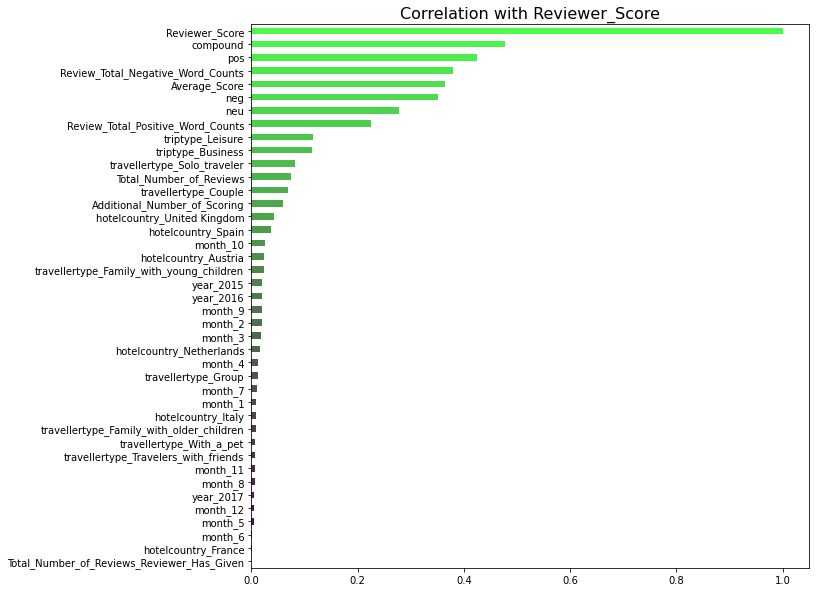

In [42]:
df_corr = df_transformed.corr()

# Get the colors for the graphic
colors = []
dim = df_corr.shape[0]
for i in range(dim):
    r = i * 1/dim
    colors.append((0.3,r,0.3))

# Transform each value in a positive value, because what interests us isn't the direction of the correlation but the absolute correlation
plt.figure(figsize=(10,10))
df_corr["Reviewer_Score"].apply(lambda x: abs(x)).sort_values().plot.barh(color = colors)

plt.title("Correlation with Reviewer_Score", fontsize = 16)
plt.show()

From this plot, we find that the top correlating columns are:
- Review_Total_Negative_Word_Counts
- Average_Score
- neu
- neg
- Review_Total_Positive_Word_Counts

# Comparing different ML models

Now we turn these columns into our features for training our model. For our regression models, we use three base models:
- LinearRegression
- GradientBoostingRegressor
- RandomForestRegressor

We construct violin plots for the prediction of reviewer score distribution from these models and compare against the actual score distribution to see which model gives the closest prediction. We also print out the mean squared error (MRSE) of each model on the title.

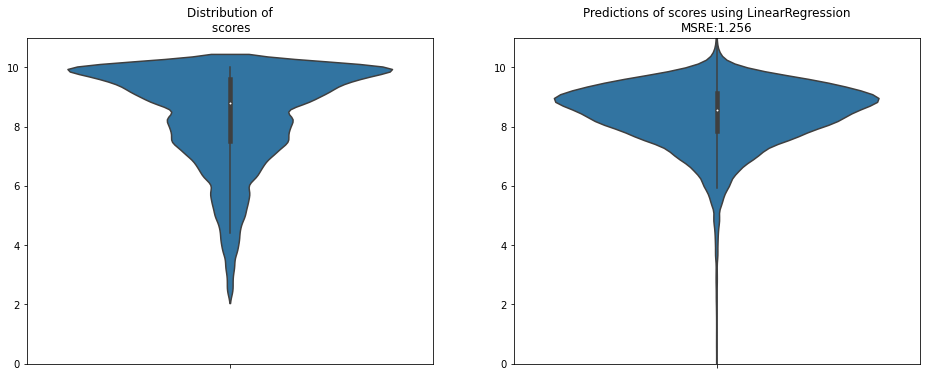

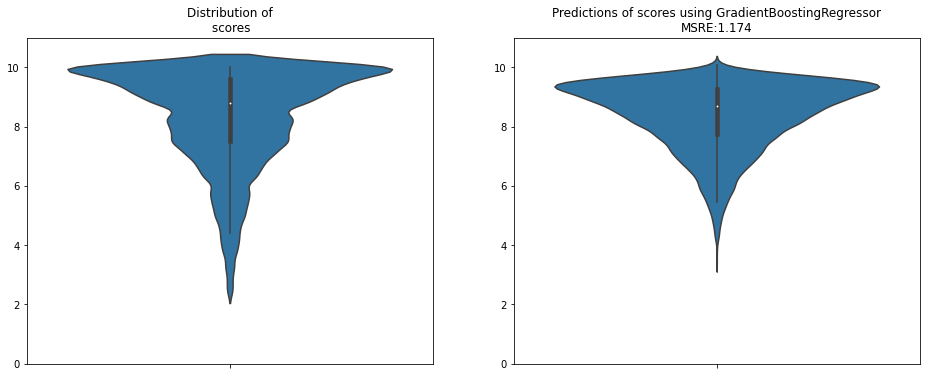

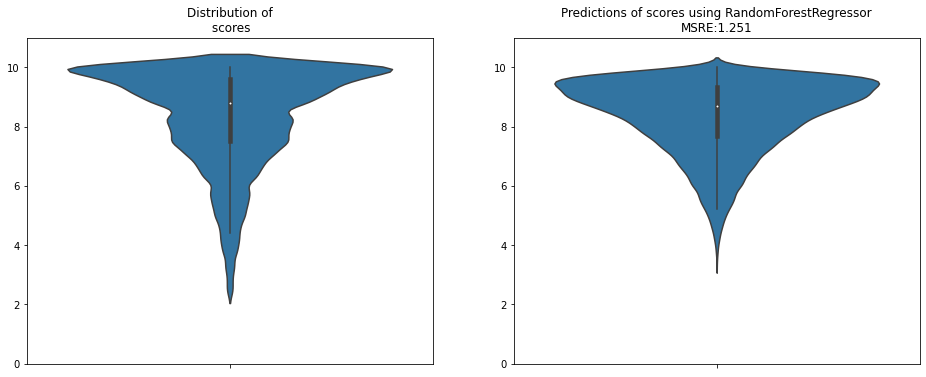

In [52]:
# Columns to use to train the models
# Only the columns with the highest correlation were chosen
cols = ['Review_Total_Negative_Word_Counts',
        'Average_Score',
        'compound',
        'Review_Total_Positive_Word_Counts']
        
X = df_transformed[cols].values
y = df_transformed["Reviewer_Score"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def plot_res(y_test,pred, model = "LinearRegression"):
# Violinplots with the distribution of real scores and predicted scores
    MSRE = round((mean_squared_error(y_test,pred))**0.5,3)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16,6))
    
    sns.violinplot(y=y_test, ax = axes[0])
    axes[0].set_title("Distribution of\n scores")
    axes[0].set_ylim(0,11)
    
    sns.violinplot(y=pred, ax = axes[1])
    title = f"Predictions of scores using {model}\nMSRE:{MSRE}"
    axes[1].set_title(title)
    axes[1].set_ylim(0,11)
    plt.show()

# LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "LinearRegression")

# GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "GradientBoostingRegressor")

# RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
plot_res(y_test,pred, model = "RandomForestRegressor")

The best base model is the GradientBoostingRegressor since it closely approximates the shape of the actual distribution of scores and has the lowest RMSE. Let's try a more complicated model called XGBoost.

In [53]:
# Splitting the data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(66014, 4)
(16504, 4)
(20630, 4)


In [54]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

**Create a scoring function with the help of XGBOOST train inbuilt early stopping**

In [55]:
# defing a function for scoring and calculation for the rmse (default for regression )
# in classification problem auc will be the default 
def return_rmse(params):
    model = xgb.train(params , dtrain, num_boost_round = 10000, evals = [(dval, 'eval')],
          early_stopping_rounds=20,verbose_eval = 0)
    result = model.eval(dval)
    result = np.float(re.search(r'[\d.]+$',result).group(0))
    return(result)

In [56]:
return_rmse(params = {}) # This is the score of rmse for the default xgboost regressor without tuning

1.178003

# Hyperparameter tuning

XGBoost is best used when we tune the hyperparameters, but doing so manually is a lot of work. We will use Optuna to help try out a range of combinations of hyperparameters to determine the combination that outputs the best result.

In [58]:
# Defining objective function for use in Optuna study
def objective(trial):
    param = {
                # "n_estimators" : trial.suggest_int('n_estimators', 0, 500), # commented as n_estimators is tuned with early stopping inside return_rmse function
                'max_depth':trial.suggest_int('max_depth', 3, 6),
                'reg_alpha':trial.suggest_uniform('reg_alpha',0,6),
                'reg_lambda':trial.suggest_uniform('reg_lambda',0,2),
                'min_child_weight':trial.suggest_int('min_child_weight',0,5),
                'gamma':trial.suggest_uniform('gamma', 0, 4),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.05,0.5),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.4,0.9),
                'subsample':trial.suggest_uniform('subsample',0.4,0.9),
                'nthread' : -1 # uses all of the cores in your system.
            }
    return(return_rmse(param)) # this will return the rmse score 

In [59]:
# Calling the optuna study
study1 = optuna.create_study(direction='minimize', sampler=TPESampler())
study1.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2021-08-25 16:38:04,512] A new study created in memory with name: no-name-8e5ce840-f981-4e73-ab36-fb314fecf00b
C:\Users\yapcm\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  1%|          | 1/100 [00:05<09:34,  5.80s/it]

[I 2021-08-25 16:38:10,311] Trial 0 finished with value: 1.169124 and parameters: {'max_depth': 4, 'reg_alpha': 5.897998304394359, 'reg_lambda': 0.9691652139453142, 'min_child_weight': 2, 'gamma': 3.730894742858003, 'learning_rate': 0.057061903085096836, 'colsample_bytree': 0.7027260048675648, 'subsample': 0.623775131396743}. Best is trial 0 with value: 1.169124.


  2%|▏         | 2/100 [00:08<06:39,  4.08s/it]

[I 2021-08-25 16:38:13,178] Trial 1 finished with value: 1.170131 and parameters: {'max_depth': 3, 'reg_alpha': 1.1481224556408436, 'reg_lambda': 1.7998819852987356, 'min_child_weight': 3, 'gamma': 3.7682213332021393, 'learning_rate': 0.13920635811137455, 'colsample_bytree': 0.7584428594415553, 'subsample': 0.5675959022133674}. Best is trial 0 with value: 1.169124.


  3%|▎         | 3/100 [00:10<04:42,  2.91s/it]

[I 2021-08-25 16:38:14,696] Trial 2 finished with value: 1.176456 and parameters: {'max_depth': 5, 'reg_alpha': 5.534047255835797, 'reg_lambda': 0.48909744189178883, 'min_child_weight': 3, 'gamma': 3.346300589116454, 'learning_rate': 0.46738097735625245, 'colsample_bytree': 0.7277615104307558, 'subsample': 0.6399214468291933}. Best is trial 0 with value: 1.169124.


  4%|▍         | 4/100 [00:12<04:00,  2.51s/it]

[I 2021-08-25 16:38:16,597] Trial 3 finished with value: 1.174881 and parameters: {'max_depth': 3, 'reg_alpha': 0.007234660597071008, 'reg_lambda': 1.6211478206126062, 'min_child_weight': 1, 'gamma': 2.2810103692970594, 'learning_rate': 0.2583357860043198, 'colsample_bytree': 0.5706201817721546, 'subsample': 0.7044447563596246}. Best is trial 0 with value: 1.169124.


  5%|▌         | 5/100 [00:17<05:41,  3.59s/it]

[I 2021-08-25 16:38:22,111] Trial 4 finished with value: 1.168077 and parameters: {'max_depth': 3, 'reg_alpha': 3.6111954789388765, 'reg_lambda': 1.5742963179358627, 'min_child_weight': 4, 'gamma': 1.74331516691564, 'learning_rate': 0.059221011968537844, 'colsample_bytree': 0.8101932510765444, 'subsample': 0.5321239898191554}. Best is trial 4 with value: 1.168077.


  6%|▌         | 6/100 [00:19<04:34,  2.92s/it]

[I 2021-08-25 16:38:23,715] Trial 5 finished with value: 1.171684 and parameters: {'max_depth': 5, 'reg_alpha': 3.391159979297723, 'reg_lambda': 0.08859692899356242, 'min_child_weight': 5, 'gamma': 1.1270447264180485, 'learning_rate': 0.1803637151436011, 'colsample_bytree': 0.647288439655413, 'subsample': 0.5023196747441715}. Best is trial 4 with value: 1.168077.


  7%|▋         | 7/100 [00:20<03:48,  2.46s/it]

[I 2021-08-25 16:38:25,220] Trial 6 finished with value: 1.171847 and parameters: {'max_depth': 4, 'reg_alpha': 0.33835482701360586, 'reg_lambda': 1.5096848676381953, 'min_child_weight': 2, 'gamma': 1.0857524532351537, 'learning_rate': 0.29494538047417096, 'colsample_bytree': 0.8854627005224307, 'subsample': 0.8455048954775288}. Best is trial 4 with value: 1.168077.


  8%|▊         | 8/100 [00:22<03:38,  2.38s/it]

[I 2021-08-25 16:38:27,426] Trial 7 finished with value: 1.172396 and parameters: {'max_depth': 3, 'reg_alpha': 2.93670549627313, 'reg_lambda': 0.7826800841778856, 'min_child_weight': 5, 'gamma': 3.2596299625197416, 'learning_rate': 0.2174632248363869, 'colsample_bytree': 0.5652091803419258, 'subsample': 0.4902702218530576}. Best is trial 4 with value: 1.168077.


  9%|▉         | 9/100 [00:24<03:03,  2.01s/it]

[I 2021-08-25 16:38:28,636] Trial 8 finished with value: 1.173391 and parameters: {'max_depth': 4, 'reg_alpha': 0.9016037697554817, 'reg_lambda': 0.852775292040735, 'min_child_weight': 4, 'gamma': 0.9453805612493125, 'learning_rate': 0.30671854869167986, 'colsample_bytree': 0.5549893450973666, 'subsample': 0.5903939045630664}. Best is trial 4 with value: 1.168077.


 10%|█         | 10/100 [00:26<03:04,  2.06s/it]

[I 2021-08-25 16:38:30,789] Trial 9 finished with value: 1.168012 and parameters: {'max_depth': 4, 'reg_alpha': 2.195632755132247, 'reg_lambda': 0.7794389697533286, 'min_child_weight': 4, 'gamma': 1.3585206089650188, 'learning_rate': 0.10848369008054143, 'colsample_bytree': 0.8107354086432317, 'subsample': 0.4725491968939464}. Best is trial 9 with value: 1.168012.


 11%|█         | 11/100 [00:29<03:47,  2.55s/it]

[I 2021-08-25 16:38:34,463] Trial 10 finished with value: 1.192569 and parameters: {'max_depth': 6, 'reg_alpha': 2.2888178330129545, 'reg_lambda': 0.3436968212562621, 'min_child_weight': 0, 'gamma': 0.10910759496523914, 'learning_rate': 0.09864969134420076, 'colsample_bytree': 0.4333304444136993, 'subsample': 0.4058835082989888}. Best is trial 9 with value: 1.168012.


 12%|█▏        | 12/100 [00:36<05:38,  3.85s/it]

[I 2021-08-25 16:38:41,279] Trial 11 finished with value: 1.167731 and parameters: {'max_depth': 3, 'reg_alpha': 4.21419107629152, 'reg_lambda': 1.3009157541492822, 'min_child_weight': 4, 'gamma': 2.0928698660361436, 'learning_rate': 0.05310274057494433, 'colsample_bytree': 0.8601029895147166, 'subsample': 0.43231388847579005}. Best is trial 11 with value: 1.167731.


 13%|█▎        | 13/100 [00:39<04:56,  3.41s/it]

[I 2021-08-25 16:38:43,681] Trial 12 finished with value: 1.167228 and parameters: {'max_depth': 4, 'reg_alpha': 4.41037406693576, 'reg_lambda': 1.1504618594654923, 'min_child_weight': 4, 'gamma': 2.449507201788241, 'learning_rate': 0.09169786630856987, 'colsample_bytree': 0.8897500583605384, 'subsample': 0.4169193508661654}. Best is trial 12 with value: 1.167228.


 14%|█▍        | 14/100 [00:41<04:36,  3.22s/it]

[I 2021-08-25 16:38:46,465] Trial 13 finished with value: 1.168077 and parameters: {'max_depth': 5, 'reg_alpha': 4.446070758647944, 'reg_lambda': 1.166249868957978, 'min_child_weight': 4, 'gamma': 2.6269124806129445, 'learning_rate': 0.07954683350316673, 'colsample_bytree': 0.8880350007950608, 'subsample': 0.40377000480390124}. Best is trial 12 with value: 1.167228.


 15%|█▌        | 15/100 [00:49<06:23,  4.51s/it]

[I 2021-08-25 16:38:53,962] Trial 14 finished with value: 1.167235 and parameters: {'max_depth': 3, 'reg_alpha': 4.675329230111383, 'reg_lambda': 1.2822348798265384, 'min_child_weight': 5, 'gamma': 2.7002202526601327, 'learning_rate': 0.05075219835136839, 'colsample_bytree': 0.8274186175822421, 'subsample': 0.7595860824898456}. Best is trial 12 with value: 1.167228.


 16%|█▌        | 16/100 [00:53<06:15,  4.47s/it]

[I 2021-08-25 16:38:58,336] Trial 15 finished with value: 1.167747 and parameters: {'max_depth': 4, 'reg_alpha': 4.975969261836428, 'reg_lambda': 1.9470830769513574, 'min_child_weight': 5, 'gamma': 2.77154365078227, 'learning_rate': 0.07781629183884517, 'colsample_bytree': 0.8128943681058801, 'subsample': 0.7431786901992433}. Best is trial 12 with value: 1.167228.


 17%|█▋        | 17/100 [00:59<06:44,  4.87s/it]

[I 2021-08-25 16:39:04,134] Trial 16 finished with value: 1.169139 and parameters: {'max_depth': 3, 'reg_alpha': 4.878696600174903, 'reg_lambda': 1.2788173930736122, 'min_child_weight': 5, 'gamma': 2.6933439862215467, 'learning_rate': 0.0752586580131932, 'colsample_bytree': 0.6496918117966701, 'subsample': 0.8454464019019405}. Best is trial 12 with value: 1.167228.


 18%|█▊        | 18/100 [01:01<05:32,  4.05s/it]

[I 2021-08-25 16:39:06,277] Trial 17 finished with value: 1.168322 and parameters: {'max_depth': 6, 'reg_alpha': 4.060262073859773, 'reg_lambda': 1.1146113355442884, 'min_child_weight': 3, 'gamma': 1.8085490243854214, 'learning_rate': 0.11836960969853591, 'colsample_bytree': 0.7753539142240568, 'subsample': 0.7811777543407536}. Best is trial 12 with value: 1.167228.


 19%|█▉        | 19/100 [01:05<05:27,  4.04s/it]

[I 2021-08-25 16:39:10,301] Trial 18 finished with value: 1.167298 and parameters: {'max_depth': 4, 'reg_alpha': 5.045024372541754, 'reg_lambda': 1.4136537132667915, 'min_child_weight': 5, 'gamma': 3.117125510169986, 'learning_rate': 0.0673365829321163, 'colsample_bytree': 0.8987546444565485, 'subsample': 0.6809999347422127}. Best is trial 12 with value: 1.167228.


 20%|██        | 20/100 [01:09<05:23,  4.05s/it]

[I 2021-08-25 16:39:14,359] Trial 19 finished with value: 1.191882 and parameters: {'max_depth': 5, 'reg_alpha': 2.886170506565799, 'reg_lambda': 1.006870367190731, 'min_child_weight': 3, 'gamma': 2.4149677239791125, 'learning_rate': 0.09003118750967332, 'colsample_bytree': 0.4045316842230608, 'subsample': 0.8988736648423099}. Best is trial 12 with value: 1.167228.


 21%|██        | 21/100 [01:14<05:30,  4.18s/it]

[I 2021-08-25 16:39:18,854] Trial 20 finished with value: 1.167703 and parameters: {'max_depth': 3, 'reg_alpha': 5.980859415762227, 'reg_lambda': 0.5742054575749578, 'min_child_weight': 4, 'gamma': 0.3439621795814771, 'learning_rate': 0.14861994480323276, 'colsample_bytree': 0.8421288568429425, 'subsample': 0.7776017648428293}. Best is trial 12 with value: 1.167228.


 22%|██▏       | 22/100 [01:18<05:34,  4.29s/it]

[I 2021-08-25 16:39:23,411] Trial 21 finished with value: 1.167755 and parameters: {'max_depth': 4, 'reg_alpha': 5.141481421414755, 'reg_lambda': 1.3894900995293296, 'min_child_weight': 5, 'gamma': 3.0883086417069157, 'learning_rate': 0.06970208134743279, 'colsample_bytree': 0.8999715456997734, 'subsample': 0.6932602078560733}. Best is trial 12 with value: 1.167228.


 23%|██▎       | 23/100 [01:23<05:27,  4.25s/it]

[I 2021-08-25 16:39:27,565] Trial 22 finished with value: 1.16749 and parameters: {'max_depth': 4, 'reg_alpha': 4.583585916210922, 'reg_lambda': 1.7269434653051379, 'min_child_weight': 5, 'gamma': 2.9838551370859645, 'learning_rate': 0.060748965412698135, 'colsample_bytree': 0.8403021288144161, 'subsample': 0.6833794575497828}. Best is trial 12 with value: 1.167228.


 24%|██▍       | 24/100 [01:27<05:31,  4.36s/it]

[I 2021-08-25 16:39:32,190] Trial 23 finished with value: 1.166865 and parameters: {'max_depth': 4, 'reg_alpha': 3.888807001969395, 'reg_lambda': 1.3983852222557198, 'min_child_weight': 5, 'gamma': 2.3156232337107863, 'learning_rate': 0.06691216592952787, 'colsample_bytree': 0.7841540792730265, 'subsample': 0.7451146771109146}. Best is trial 23 with value: 1.166865.


 25%|██▌       | 25/100 [01:33<06:05,  4.87s/it]

[I 2021-08-25 16:39:38,246] Trial 24 finished with value: 1.168633 and parameters: {'max_depth': 5, 'reg_alpha': 3.82470966006119, 'reg_lambda': 1.1958921387536003, 'min_child_weight': 4, 'gamma': 1.5761276345467357, 'learning_rate': 0.051465314278616205, 'colsample_bytree': 0.6966882399761307, 'subsample': 0.7464880747269046}. Best is trial 23 with value: 1.166865.


 26%|██▌       | 26/100 [01:38<06:02,  4.90s/it]

[I 2021-08-25 16:39:43,230] Trial 25 finished with value: 1.167258 and parameters: {'max_depth': 4, 'reg_alpha': 3.4044506625808215, 'reg_lambda': 1.0302158923374902, 'min_child_weight': 5, 'gamma': 2.1298948326206206, 'learning_rate': 0.08476616101713767, 'colsample_bytree': 0.7666955598841703, 'subsample': 0.818439134832625}. Best is trial 23 with value: 1.166865.


 27%|██▋       | 27/100 [01:42<05:39,  4.65s/it]

[I 2021-08-25 16:39:47,284] Trial 26 finished with value: 1.167759 and parameters: {'max_depth': 3, 'reg_alpha': 2.424083077344391, 'reg_lambda': 1.4360777101740283, 'min_child_weight': 4, 'gamma': 2.497340805765275, 'learning_rate': 0.11206628165563232, 'colsample_bytree': 0.7927637264820986, 'subsample': 0.7329161322697237}. Best is trial 23 with value: 1.166865.


 28%|██▊       | 28/100 [01:47<05:31,  4.61s/it]

[I 2021-08-25 16:39:51,799] Trial 27 finished with value: 1.167294 and parameters: {'max_depth': 4, 'reg_alpha': 4.526284173078638, 'reg_lambda': 1.9888915204741644, 'min_child_weight': 5, 'gamma': 1.9301452480251076, 'learning_rate': 0.12826777707176326, 'colsample_bytree': 0.8512458381974067, 'subsample': 0.7958036223372827}. Best is trial 23 with value: 1.166865.


 29%|██▉       | 29/100 [01:51<05:08,  4.35s/it]

[I 2021-08-25 16:39:55,541] Trial 28 finished with value: 1.169799 and parameters: {'max_depth': 5, 'reg_alpha': 5.453581376751228, 'reg_lambda': 1.7160137058638318, 'min_child_weight': 2, 'gamma': 3.485609274303938, 'learning_rate': 0.09765258930602304, 'colsample_bytree': 0.7453439944216819, 'subsample': 0.8963619492232562}. Best is trial 23 with value: 1.166865.


 30%|███       | 30/100 [01:57<05:39,  4.85s/it]

[I 2021-08-25 16:40:01,575] Trial 29 finished with value: 1.169653 and parameters: {'max_depth': 3, 'reg_alpha': 3.907314715910922, 'reg_lambda': 1.3018633838600162, 'min_child_weight': 1, 'gamma': 2.9170317451847914, 'learning_rate': 0.06607955797269843, 'colsample_bytree': 0.6867108727888339, 'subsample': 0.6148581016881114}. Best is trial 23 with value: 1.166865.


 31%|███       | 31/100 [01:59<04:37,  4.02s/it]

[I 2021-08-25 16:40:03,651] Trial 30 finished with value: 1.170562 and parameters: {'max_depth': 6, 'reg_alpha': 5.681082598641817, 'reg_lambda': 0.8862592551324848, 'min_child_weight': 3, 'gamma': 2.360313221815684, 'learning_rate': 0.1741674315196356, 'colsample_bytree': 0.617806229515497, 'subsample': 0.6616443009717567}. Best is trial 23 with value: 1.166865.


 32%|███▏      | 32/100 [02:04<04:59,  4.40s/it]

[I 2021-08-25 16:40:08,938] Trial 31 finished with value: 1.167826 and parameters: {'max_depth': 4, 'reg_alpha': 3.266817431484575, 'reg_lambda': 1.0320562060623284, 'min_child_weight': 5, 'gamma': 2.1158687217048033, 'learning_rate': 0.08649143561654277, 'colsample_bytree': 0.7810384714986858, 'subsample': 0.8402437084704943}. Best is trial 23 with value: 1.166865.


 33%|███▎      | 33/100 [02:09<05:06,  4.57s/it]

[I 2021-08-25 16:40:13,914] Trial 32 finished with value: 1.169836 and parameters: {'max_depth': 4, 'reg_alpha': 3.3109493780140964, 'reg_lambda': 1.1122061866028148, 'min_child_weight': 5, 'gamma': 2.1598458142649277, 'learning_rate': 0.05928213428848355, 'colsample_bytree': 0.7342901308547294, 'subsample': 0.8091400064985383}. Best is trial 23 with value: 1.166865.


 34%|███▍      | 34/100 [02:13<04:56,  4.50s/it]

[I 2021-08-25 16:40:18,239] Trial 33 finished with value: 1.169825 and parameters: {'max_depth': 4, 'reg_alpha': 4.283391047075925, 'reg_lambda': 0.643896967358554, 'min_child_weight': 5, 'gamma': 3.8562442439751137, 'learning_rate': 0.0869140128278331, 'colsample_bytree': 0.7149123834560785, 'subsample': 0.7223544478513363}. Best is trial 23 with value: 1.166865.


 35%|███▌      | 35/100 [02:19<05:21,  4.95s/it]

[I 2021-08-25 16:40:24,231] Trial 34 finished with value: 1.167917 and parameters: {'max_depth': 4, 'reg_alpha': 2.6379254281393587, 'reg_lambda': 0.9574133777810251, 'min_child_weight': 4, 'gamma': 1.5619457190771935, 'learning_rate': 0.053624293391429274, 'colsample_bytree': 0.7599537179695494, 'subsample': 0.8097632137743762}. Best is trial 23 with value: 1.166865.


 36%|███▌      | 36/100 [02:20<04:04,  3.82s/it]

[I 2021-08-25 16:40:25,421] Trial 35 finished with value: 1.173842 and parameters: {'max_depth': 3, 'reg_alpha': 3.692200593049229, 'reg_lambda': 1.2485443156981177, 'min_child_weight': 5, 'gamma': 3.6318904011157223, 'learning_rate': 0.49342708267149454, 'colsample_bytree': 0.8298911902417175, 'subsample': 0.7576547273149001}. Best is trial 23 with value: 1.166865.


 37%|███▋      | 37/100 [02:25<04:10,  3.98s/it]

[I 2021-08-25 16:40:29,776] Trial 36 finished with value: 1.167508 and parameters: {'max_depth': 5, 'reg_alpha': 2.0301238132296886, 'reg_lambda': 1.5026885115929591, 'min_child_weight': 4, 'gamma': 2.5115527815733083, 'learning_rate': 0.05026736051932621, 'colsample_bytree': 0.8684527766188375, 'subsample': 0.5405753352418677}. Best is trial 23 with value: 1.166865.


 38%|███▊      | 38/100 [02:30<04:33,  4.41s/it]

[I 2021-08-25 16:40:35,198] Trial 37 finished with value: 1.168016 and parameters: {'max_depth': 3, 'reg_alpha': 4.695307050747136, 'reg_lambda': 1.630986564955809, 'min_child_weight': 3, 'gamma': 2.8312620561509942, 'learning_rate': 0.06354212537228357, 'colsample_bytree': 0.8078044388814986, 'subsample': 0.6324019821643241}. Best is trial 23 with value: 1.166865.


 39%|███▉      | 39/100 [02:31<03:28,  3.42s/it]

[I 2021-08-25 16:40:36,315] Trial 38 finished with value: 1.174501 and parameters: {'max_depth': 4, 'reg_alpha': 5.372603045002372, 'reg_lambda': 1.0144611887260047, 'min_child_weight': 5, 'gamma': 2.270398732947879, 'learning_rate': 0.408751280331657, 'colsample_bytree': 0.7723343399363857, 'subsample': 0.872855029556032}. Best is trial 23 with value: 1.166865.


 40%|████      | 40/100 [02:35<03:32,  3.55s/it]

[I 2021-08-25 16:40:40,149] Trial 39 finished with value: 1.168882 and parameters: {'max_depth': 5, 'reg_alpha': 1.685922092236052, 'reg_lambda': 1.3568277461299971, 'min_child_weight': 4, 'gamma': 1.9153402012167757, 'learning_rate': 0.07422113765741364, 'colsample_bytree': 0.6799558552240332, 'subsample': 0.7093365067102916}. Best is trial 23 with value: 1.166865.


 41%|████      | 41/100 [02:39<03:35,  3.65s/it]

[I 2021-08-25 16:40:44,043] Trial 40 finished with value: 1.191867 and parameters: {'max_depth': 4, 'reg_alpha': 3.53739730061869, 'reg_lambda': 0.6995539849068981, 'min_child_weight': 1, 'gamma': 1.5933339071423818, 'learning_rate': 0.10144878763665521, 'colsample_bytree': 0.4919269324160087, 'subsample': 0.8220150006303515}. Best is trial 23 with value: 1.166865.


 42%|████▏     | 42/100 [02:42<03:21,  3.47s/it]

[I 2021-08-25 16:40:47,101] Trial 41 finished with value: 1.168007 and parameters: {'max_depth': 4, 'reg_alpha': 4.4299919160768235, 'reg_lambda': 1.9898399859520444, 'min_child_weight': 5, 'gamma': 1.8899031480731343, 'learning_rate': 0.1320799254042026, 'colsample_bytree': 0.8624395452432672, 'subsample': 0.7823274505857528}. Best is trial 23 with value: 1.166865.


 43%|████▎     | 43/100 [02:44<02:54,  3.06s/it]

[I 2021-08-25 16:40:49,193] Trial 42 finished with value: 1.16884 and parameters: {'max_depth': 4, 'reg_alpha': 4.038269477668211, 'reg_lambda': 1.7892283084225298, 'min_child_weight': 5, 'gamma': 1.9851746816453897, 'learning_rate': 0.13539522687960356, 'colsample_bytree': 0.835537247117435, 'subsample': 0.7658370564696333}. Best is trial 23 with value: 1.166865.


 44%|████▍     | 44/100 [02:46<02:31,  2.71s/it]

[I 2021-08-25 16:40:51,100] Trial 43 finished with value: 1.168238 and parameters: {'max_depth': 4, 'reg_alpha': 3.1160566972543844, 'reg_lambda': 1.5385502397723807, 'min_child_weight': 5, 'gamma': 1.294232993085227, 'learning_rate': 0.16300008000631258, 'colsample_bytree': 0.8673034802393758, 'subsample': 0.7992641335922557}. Best is trial 23 with value: 1.166865.


 45%|████▌     | 45/100 [02:47<02:06,  2.29s/it]

[I 2021-08-25 16:40:52,409] Trial 44 finished with value: 1.170485 and parameters: {'max_depth': 4, 'reg_alpha': 4.686857438131088, 'reg_lambda': 1.8960539042809597, 'min_child_weight': 5, 'gamma': 2.282508905844379, 'learning_rate': 0.21975876097802494, 'colsample_bytree': 0.80056967351505, 'subsample': 0.8707439635641457}. Best is trial 23 with value: 1.166865.


 46%|████▌     | 46/100 [02:52<02:44,  3.05s/it]

[I 2021-08-25 16:40:57,231] Trial 45 finished with value: 1.167721 and parameters: {'max_depth': 3, 'reg_alpha': 3.5945051222451894, 'reg_lambda': 0.31075652689479916, 'min_child_weight': 4, 'gamma': 2.6060054479661114, 'learning_rate': 0.11767123489358321, 'colsample_bytree': 0.8248154257185497, 'subsample': 0.5946959021913263}. Best is trial 23 with value: 1.166865.


 47%|████▋     | 47/100 [02:56<02:51,  3.24s/it]

[I 2021-08-25 16:41:00,926] Trial 46 finished with value: 1.168344 and parameters: {'max_depth': 4, 'reg_alpha': 4.26697994910938, 'reg_lambda': 1.1188512555748205, 'min_child_weight': 4, 'gamma': 3.239071680482228, 'learning_rate': 0.09377114769058305, 'colsample_bytree': 0.8498982166467028, 'subsample': 0.6597437122340558}. Best is trial 23 with value: 1.166865.


 48%|████▊     | 48/100 [03:01<03:22,  3.90s/it]

[I 2021-08-25 16:41:06,343] Trial 47 finished with value: 1.167432 and parameters: {'max_depth': 3, 'reg_alpha': 5.274703743833905, 'reg_lambda': 0.8456877534393022, 'min_child_weight': 5, 'gamma': 0.7704784595987086, 'learning_rate': 0.08282725194752938, 'colsample_bytree': 0.7513953553658875, 'subsample': 0.7188081068565468}. Best is trial 23 with value: 1.166865.


 49%|████▉     | 49/100 [03:06<03:24,  4.01s/it]

[I 2021-08-25 16:41:10,623] Trial 48 finished with value: 1.168175 and parameters: {'max_depth': 5, 'reg_alpha': 4.7963050880213975, 'reg_lambda': 1.6602166072991635, 'min_child_weight': 0, 'gamma': 1.6860101575610416, 'learning_rate': 0.0697950842552271, 'colsample_bytree': 0.8777892983857933, 'subsample': 0.44944343724771413}. Best is trial 23 with value: 1.166865.


 50%|█████     | 50/100 [03:11<03:41,  4.43s/it]

[I 2021-08-25 16:41:16,019] Trial 49 finished with value: 1.167087 and parameters: {'max_depth': 4, 'reg_alpha': 5.703681073062799, 'reg_lambda': 1.878069613449383, 'min_child_weight': 5, 'gamma': 2.146783704587814, 'learning_rate': 0.05838825024897697, 'colsample_bytree': 0.7864199745573534, 'subsample': 0.8347964258522461}. Best is trial 23 with value: 1.166865.


 51%|█████     | 51/100 [03:17<04:00,  4.90s/it]

[I 2021-08-25 16:41:22,021] Trial 50 finished with value: 1.170007 and parameters: {'max_depth': 3, 'reg_alpha': 5.6669139377881415, 'reg_lambda': 1.829315204608219, 'min_child_weight': 4, 'gamma': 2.771692494914155, 'learning_rate': 0.05598267158748173, 'colsample_bytree': 0.7275419227304194, 'subsample': 0.8250512348908278}. Best is trial 23 with value: 1.166865.


 52%|█████▏    | 52/100 [03:22<04:00,  5.01s/it]

[I 2021-08-25 16:41:27,270] Trial 51 finished with value: 1.167659 and parameters: {'max_depth': 4, 'reg_alpha': 4.181505971338213, 'reg_lambda': 1.8432269691434615, 'min_child_weight': 5, 'gamma': 2.227958214823236, 'learning_rate': 0.05875755534704782, 'colsample_bytree': 0.8182045114342139, 'subsample': 0.8698473945091584}. Best is trial 23 with value: 1.166865.


 53%|█████▎    | 53/100 [03:27<03:57,  5.05s/it]

[I 2021-08-25 16:41:32,430] Trial 52 finished with value: 1.167332 and parameters: {'max_depth': 4, 'reg_alpha': 3.857391807559214, 'reg_lambda': 1.8924455764380115, 'min_child_weight': 5, 'gamma': 1.976028810802584, 'learning_rate': 0.07452202372379954, 'colsample_bytree': 0.7874647745166556, 'subsample': 0.7873322910789814}. Best is trial 23 with value: 1.166865.


 54%|█████▍    | 54/100 [03:30<03:16,  4.27s/it]

[I 2021-08-25 16:41:34,884] Trial 53 finished with value: 1.167883 and parameters: {'max_depth': 4, 'reg_alpha': 4.506628110079843, 'reg_lambda': 1.2126393875261081, 'min_child_weight': 5, 'gamma': 2.0522033704415343, 'learning_rate': 0.12332901752749482, 'colsample_bytree': 0.7664179426403575, 'subsample': 0.8332690096151948}. Best is trial 23 with value: 1.166865.


 55%|█████▌    | 55/100 [03:34<03:07,  4.16s/it]

[I 2021-08-25 16:41:38,794] Trial 54 finished with value: 1.169593 and parameters: {'max_depth': 4, 'reg_alpha': 4.892194089157947, 'reg_lambda': 0.9372438809320132, 'min_child_weight': 5, 'gamma': 2.4315115528259335, 'learning_rate': 0.10665808514206832, 'colsample_bytree': 0.6198612531678034, 'subsample': 0.5169206284117892}. Best is trial 23 with value: 1.166865.


 56%|█████▌    | 56/100 [03:39<03:18,  4.52s/it]

[I 2021-08-25 16:41:44,147] Trial 55 finished with value: 1.166912 and parameters: {'max_depth': 4, 'reg_alpha': 5.757830187074195, 'reg_lambda': 1.486226212805986, 'min_child_weight': 2, 'gamma': 1.3865282886419896, 'learning_rate': 0.06370041719897865, 'colsample_bytree': 0.8537322365786042, 'subsample': 0.8581816541492147}. Best is trial 23 with value: 1.166865.


 57%|█████▋    | 57/100 [03:44<03:14,  4.53s/it]

[I 2021-08-25 16:41:48,708] Trial 56 finished with value: 1.167021 and parameters: {'max_depth': 4, 'reg_alpha': 5.794134386038714, 'reg_lambda': 1.486523133463511, 'min_child_weight': 2, 'gamma': 0.7308246591201157, 'learning_rate': 0.06322842370175116, 'colsample_bytree': 0.8838631291619632, 'subsample': 0.763141243245085}. Best is trial 23 with value: 1.166865.


 58%|█████▊    | 58/100 [03:48<03:06,  4.44s/it]

[I 2021-08-25 16:41:52,922] Trial 57 finished with value: 1.168269 and parameters: {'max_depth': 5, 'reg_alpha': 5.775369360549697, 'reg_lambda': 1.515136941532243, 'min_child_weight': 2, 'gamma': 0.557867617613377, 'learning_rate': 0.06348624849458795, 'colsample_bytree': 0.8838856469254617, 'subsample': 0.8591152357718217}. Best is trial 23 with value: 1.166865.


 59%|█████▉    | 59/100 [03:54<03:23,  4.97s/it]

[I 2021-08-25 16:41:59,145] Trial 58 finished with value: 1.166438 and parameters: {'max_depth': 4, 'reg_alpha': 5.968374987878846, 'reg_lambda': 1.4374979276040596, 'min_child_weight': 2, 'gamma': 0.8899280869658877, 'learning_rate': 0.05539358203635937, 'colsample_bytree': 0.8951338853974595, 'subsample': 0.7584140284053172}. Best is trial 58 with value: 1.166438.


 60%|██████    | 60/100 [03:59<03:19,  4.99s/it]

[I 2021-08-25 16:42:04,187] Trial 59 finished with value: 1.166504 and parameters: {'max_depth': 4, 'reg_alpha': 5.96999911305706, 'reg_lambda': 1.4343516228278657, 'min_child_weight': 1, 'gamma': 0.973040268992033, 'learning_rate': 0.05598518725872079, 'colsample_bytree': 0.8938960389744589, 'subsample': 0.7439855349296409}. Best is trial 58 with value: 1.166438.


 61%|██████    | 61/100 [04:06<03:32,  5.46s/it]

[I 2021-08-25 16:42:10,729] Trial 60 finished with value: 1.166579 and parameters: {'max_depth': 4, 'reg_alpha': 5.996208731320077, 'reg_lambda': 1.444902642875764, 'min_child_weight': 1, 'gamma': 0.8772077748627387, 'learning_rate': 0.05532670957439813, 'colsample_bytree': 0.8781165643960489, 'subsample': 0.7385147666521715}. Best is trial 58 with value: 1.166438.


 62%|██████▏   | 62/100 [04:10<03:18,  5.23s/it]

[I 2021-08-25 16:42:15,436] Trial 61 finished with value: 1.167015 and parameters: {'max_depth': 4, 'reg_alpha': 5.955149967038237, 'reg_lambda': 1.4552310663682553, 'min_child_weight': 1, 'gamma': 0.8590122693644987, 'learning_rate': 0.05546306196446496, 'colsample_bytree': 0.8979987484899096, 'subsample': 0.7394634234562875}. Best is trial 58 with value: 1.166438.


 63%|██████▎   | 63/100 [04:15<03:06,  5.05s/it]

[I 2021-08-25 16:42:20,057] Trial 62 finished with value: 1.16708 and parameters: {'max_depth': 4, 'reg_alpha': 5.973739883401087, 'reg_lambda': 1.455150425970254, 'min_child_weight': 1, 'gamma': 0.8953957079595398, 'learning_rate': 0.05549953923320124, 'colsample_bytree': 0.8978004261620512, 'subsample': 0.7402530865929604}. Best is trial 58 with value: 1.166438.


 64%|██████▍   | 64/100 [04:20<02:57,  4.93s/it]

[I 2021-08-25 16:42:24,717] Trial 63 finished with value: 1.16753 and parameters: {'max_depth': 4, 'reg_alpha': 5.475435926205798, 'reg_lambda': 1.5892341768664784, 'min_child_weight': 2, 'gamma': 1.1153347039298442, 'learning_rate': 0.07051909558458343, 'colsample_bytree': 0.8737090245839169, 'subsample': 0.7525482644623869}. Best is trial 58 with value: 1.166438.


 65%|██████▌   | 65/100 [04:24<02:47,  4.78s/it]

[I 2021-08-25 16:42:29,135] Trial 64 finished with value: 1.167781 and parameters: {'max_depth': 4, 'reg_alpha': 5.231366141218566, 'reg_lambda': 1.3396255405034427, 'min_child_weight': 1, 'gamma': 0.6616454008833397, 'learning_rate': 0.06403262305160386, 'colsample_bytree': 0.8547606936476378, 'subsample': 0.7008207275542123}. Best is trial 58 with value: 1.166438.


 66%|██████▌   | 66/100 [04:30<02:51,  5.03s/it]

[I 2021-08-25 16:42:34,756] Trial 65 finished with value: 1.166606 and parameters: {'max_depth': 4, 'reg_alpha': 5.866373157685532, 'reg_lambda': 1.464888235088312, 'min_child_weight': 1, 'gamma': 0.39485786674323553, 'learning_rate': 0.054870853641804315, 'colsample_bytree': 0.8865734414113738, 'subsample': 0.7695283792786851}. Best is trial 58 with value: 1.166438.


 67%|██████▋   | 67/100 [04:34<02:39,  4.84s/it]

[I 2021-08-25 16:42:39,143] Trial 66 finished with value: 1.167533 and parameters: {'max_depth': 4, 'reg_alpha': 5.946228600514027, 'reg_lambda': 1.3821796646654352, 'min_child_weight': 1, 'gamma': 0.3075132988792312, 'learning_rate': 0.0549719798070782, 'colsample_bytree': 0.898467101290739, 'subsample': 0.7286733244360694}. Best is trial 58 with value: 1.166438.


 68%|██████▊   | 68/100 [04:39<02:35,  4.86s/it]

[I 2021-08-25 16:42:44,049] Trial 67 finished with value: 1.167263 and parameters: {'max_depth': 4, 'reg_alpha': 5.497922224561678, 'reg_lambda': 1.566415076172182, 'min_child_weight': 0, 'gamma': 1.2553225086442592, 'learning_rate': 0.0508876934612211, 'colsample_bytree': 0.8452584369911951, 'subsample': 0.6763230790847382}. Best is trial 58 with value: 1.166438.


 69%|██████▉   | 69/100 [04:44<02:28,  4.78s/it]

[I 2021-08-25 16:42:48,651] Trial 68 finished with value: 1.167369 and parameters: {'max_depth': 4, 'reg_alpha': 5.57173869365411, 'reg_lambda': 1.6973517248385708, 'min_child_weight': 1, 'gamma': 0.9715619789669395, 'learning_rate': 0.05988649775421792, 'colsample_bytree': 0.8763412283741739, 'subsample': 0.7034398799856422}. Best is trial 58 with value: 1.166438.


 70%|███████   | 70/100 [04:49<02:25,  4.84s/it]

[I 2021-08-25 16:42:53,633] Trial 69 finished with value: 1.167045 and parameters: {'max_depth': 4, 'reg_alpha': 5.126459904083581, 'reg_lambda': 1.4409897262638969, 'min_child_weight': 1, 'gamma': 0.3859465216027687, 'learning_rate': 0.0680425393078839, 'colsample_bytree': 0.8597069390997528, 'subsample': 0.7689968800967739}. Best is trial 58 with value: 1.166438.


 71%|███████   | 71/100 [04:53<02:16,  4.71s/it]

[I 2021-08-25 16:42:58,040] Trial 70 finished with value: 1.167179 and parameters: {'max_depth': 4, 'reg_alpha': 5.9949368672740615, 'reg_lambda': 1.3110925190025036, 'min_child_weight': 2, 'gamma': 0.5287446404006572, 'learning_rate': 0.054968768181052396, 'colsample_bytree': 0.8894571000880865, 'subsample': 0.7333662008802153}. Best is trial 58 with value: 1.166438.


 72%|███████▏  | 72/100 [04:57<02:06,  4.52s/it]

[I 2021-08-25 16:43:02,118] Trial 71 finished with value: 1.167505 and parameters: {'max_depth': 4, 'reg_alpha': 5.8033257742535405, 'reg_lambda': 1.4839686224410678, 'min_child_weight': 2, 'gamma': 0.8165590981258198, 'learning_rate': 0.06395637489920974, 'colsample_bytree': 0.8832938141412491, 'subsample': 0.7667253761831176}. Best is trial 58 with value: 1.166438.


 73%|███████▎  | 73/100 [05:01<01:56,  4.33s/it]

[I 2021-08-25 16:43:05,988] Trial 72 finished with value: 1.167006 and parameters: {'max_depth': 4, 'reg_alpha': 5.772618771205878, 'reg_lambda': 1.603221433405026, 'min_child_weight': 2, 'gamma': 0.06102438155777856, 'learning_rate': 0.06065670846371028, 'colsample_bytree': 0.8402160965227461, 'subsample': 0.7447938920507119}. Best is trial 58 with value: 1.166438.


 74%|███████▍  | 74/100 [05:05<01:52,  4.32s/it]

[I 2021-08-25 16:43:10,310] Trial 73 finished with value: 1.167199 and parameters: {'max_depth': 4, 'reg_alpha': 5.316617583092247, 'reg_lambda': 1.605263798660674, 'min_child_weight': 1, 'gamma': 0.08070954800809277, 'learning_rate': 0.07963073520628036, 'colsample_bytree': 0.8441926055413931, 'subsample': 0.7471680148669854}. Best is trial 58 with value: 1.166438.


 75%|███████▌  | 75/100 [05:11<01:54,  4.59s/it]

[I 2021-08-25 16:43:15,513] Trial 74 finished with value: 1.167328 and parameters: {'max_depth': 4, 'reg_alpha': 5.594262105006886, 'reg_lambda': 1.4028063033827936, 'min_child_weight': 2, 'gamma': 0.203492915511671, 'learning_rate': 0.05265522157146225, 'colsample_bytree': 0.82253092951162, 'subsample': 0.6860741048225724}. Best is trial 58 with value: 1.166438.


 76%|███████▌  | 76/100 [05:16<01:53,  4.73s/it]

[I 2021-08-25 16:43:20,564] Trial 75 finished with value: 1.166774 and parameters: {'max_depth': 4, 'reg_alpha': 5.814782412064184, 'reg_lambda': 1.6694116102555727, 'min_child_weight': 0, 'gamma': 0.5296867119175741, 'learning_rate': 0.060112193671845886, 'colsample_bytree': 0.8642715392540742, 'subsample': 0.7198715623037005}. Best is trial 58 with value: 1.166438.


 77%|███████▋  | 77/100 [05:19<01:40,  4.37s/it]

[I 2021-08-25 16:43:24,094] Trial 76 finished with value: 1.168299 and parameters: {'max_depth': 4, 'reg_alpha': 0.574580642696664, 'reg_lambda': 1.7736925791852454, 'min_child_weight': 0, 'gamma': 1.0093090194027063, 'learning_rate': 0.07426486088107485, 'colsample_bytree': 0.8644530339188928, 'subsample': 0.7153362021861214}. Best is trial 58 with value: 1.166438.


 78%|███████▊  | 78/100 [05:24<01:39,  4.54s/it]

[I 2021-08-25 16:43:29,040] Trial 77 finished with value: 1.167083 and parameters: {'max_depth': 4, 'reg_alpha': 5.8093398024422935, 'reg_lambda': 1.65743558097534, 'min_child_weight': 3, 'gamma': 0.45022483690994974, 'learning_rate': 0.05984107321648547, 'colsample_bytree': 0.8393015924625498, 'subsample': 0.7948895487935572}. Best is trial 58 with value: 1.166438.


 79%|███████▉  | 79/100 [05:28<01:29,  4.27s/it]

[I 2021-08-25 16:43:32,677] Trial 78 finished with value: 1.168148 and parameters: {'max_depth': 5, 'reg_alpha': 5.0729624121992085, 'reg_lambda': 1.5539376209654383, 'min_child_weight': 0, 'gamma': 0.2252790864721835, 'learning_rate': 0.06935183373345678, 'colsample_bytree': 0.8077570845680603, 'subsample': 0.8061857415256543}. Best is trial 58 with value: 1.166438.


 80%|████████  | 80/100 [05:33<01:32,  4.64s/it]

[I 2021-08-25 16:43:38,192] Trial 79 finished with value: 1.167549 and parameters: {'max_depth': 4, 'reg_alpha': 5.40299412427114, 'reg_lambda': 1.2493734245199442, 'min_child_weight': 2, 'gamma': 0.5802211590480268, 'learning_rate': 0.05098693062539366, 'colsample_bytree': 0.8747795745818095, 'subsample': 0.6507225727200822}. Best is trial 58 with value: 1.166438.


 81%|████████  | 81/100 [05:35<01:10,  3.71s/it]

[I 2021-08-25 16:43:39,731] Trial 80 finished with value: 1.171037 and parameters: {'max_depth': 4, 'reg_alpha': 5.633505634026761, 'reg_lambda': 1.7580422785817236, 'min_child_weight': 2, 'gamma': 1.207041927005389, 'learning_rate': 0.3362081707717567, 'colsample_bytree': 0.855898272123834, 'subsample': 0.782152540700194}. Best is trial 58 with value: 1.166438.


 82%|████████▏ | 82/100 [05:40<01:14,  4.13s/it]

[I 2021-08-25 16:43:44,827] Trial 81 finished with value: 1.16659 and parameters: {'max_depth': 4, 'reg_alpha': 5.879514843903562, 'reg_lambda': 1.3421669180205373, 'min_child_weight': 1, 'gamma': 0.8534583486802509, 'learning_rate': 0.05717925989930401, 'colsample_bytree': 0.8909875654976298, 'subsample': 0.7257505372916805}. Best is trial 58 with value: 1.166438.


 83%|████████▎ | 83/100 [05:44<01:09,  4.09s/it]

[I 2021-08-25 16:43:48,825] Trial 82 finished with value: 1.167193 and parameters: {'max_depth': 4, 'reg_alpha': 5.781156297152754, 'reg_lambda': 1.3352306109295855, 'min_child_weight': 1, 'gamma': 1.4140551074168584, 'learning_rate': 0.057499004089213705, 'colsample_bytree': 0.8354657852579264, 'subsample': 0.723140782633672}. Best is trial 58 with value: 1.166438.


 84%|████████▍ | 84/100 [05:49<01:08,  4.28s/it]

[I 2021-08-25 16:43:53,561] Trial 83 finished with value: 1.167624 and parameters: {'max_depth': 4, 'reg_alpha': 5.530868027754975, 'reg_lambda': 1.6772302033019606, 'min_child_weight': 1, 'gamma': 0.6891116646956528, 'learning_rate': 0.06206498845960939, 'colsample_bytree': 0.8652153101006587, 'subsample': 0.7505365838203589}. Best is trial 58 with value: 1.166438.


 85%|████████▌ | 85/100 [05:55<01:12,  4.80s/it]

[I 2021-08-25 16:43:59,570] Trial 84 finished with value: 1.16843 and parameters: {'max_depth': 4, 'reg_alpha': 5.853154297686104, 'reg_lambda': 1.613423833528922, 'min_child_weight': 0, 'gamma': 0.012246871487843765, 'learning_rate': 0.06776497566632467, 'colsample_bytree': 0.545581048487139, 'subsample': 0.6723924420948182}. Best is trial 58 with value: 1.166438.


 86%|████████▌ | 86/100 [05:58<01:03,  4.53s/it]

[I 2021-08-25 16:44:03,475] Trial 85 finished with value: 1.167448 and parameters: {'max_depth': 4, 'reg_alpha': 5.208238539125263, 'reg_lambda': 1.3912715668076319, 'min_child_weight': 1, 'gamma': 1.064875837066835, 'learning_rate': 0.05379461099578421, 'colsample_bytree': 0.8904146240121922, 'subsample': 0.7108956820941089}. Best is trial 58 with value: 1.166438.


 87%|████████▋ | 87/100 [06:05<01:04,  5.00s/it]

[I 2021-08-25 16:44:09,543] Trial 86 finished with value: 1.16718 and parameters: {'max_depth': 4, 'reg_alpha': 5.389316683622628, 'reg_lambda': 1.5671915799810534, 'min_child_weight': 2, 'gamma': 1.455544060573427, 'learning_rate': 0.05024344429901303, 'colsample_bytree': 0.8515831379954224, 'subsample': 0.7746550746294288}. Best is trial 58 with value: 1.166438.


 88%|████████▊ | 88/100 [06:09<00:56,  4.72s/it]

[I 2021-08-25 16:44:13,617] Trial 87 finished with value: 1.167683 and parameters: {'max_depth': 4, 'reg_alpha': 1.2368956046321258, 'reg_lambda': 1.5187049615299042, 'min_child_weight': 1, 'gamma': 0.4551318336480749, 'learning_rate': 0.060766337216454844, 'colsample_bytree': 0.8740143351125551, 'subsample': 0.697520070590205}. Best is trial 58 with value: 1.166438.


 89%|████████▉ | 89/100 [06:13<00:51,  4.65s/it]

[I 2021-08-25 16:44:18,123] Trial 88 finished with value: 1.167189 and parameters: {'max_depth': 4, 'reg_alpha': 5.663330027183217, 'reg_lambda': 1.2795780303513093, 'min_child_weight': 0, 'gamma': 0.319183469256954, 'learning_rate': 0.07824007367539393, 'colsample_bytree': 0.8257780426770016, 'subsample': 0.7321764750060171}. Best is trial 58 with value: 1.166438.


 90%|█████████ | 90/100 [06:18<00:47,  4.76s/it]

[I 2021-08-25 16:44:23,139] Trial 89 finished with value: 1.167307 and parameters: {'max_depth': 4, 'reg_alpha': 5.858021555252804, 'reg_lambda': 1.1616453071191408, 'min_child_weight': 3, 'gamma': 0.18776032753587493, 'learning_rate': 0.07230138369990546, 'colsample_bytree': 0.8051523686799635, 'subsample': 0.7580879893661843}. Best is trial 58 with value: 1.166438.


 91%|█████████ | 91/100 [06:23<00:43,  4.84s/it]

[I 2021-08-25 16:44:28,163] Trial 90 finished with value: 1.166903 and parameters: {'max_depth': 4, 'reg_alpha': 4.964560587107045, 'reg_lambda': 1.7348718271998935, 'min_child_weight': 2, 'gamma': 1.1758551759214222, 'learning_rate': 0.06543009416020118, 'colsample_bytree': 0.8882523738257155, 'subsample': 0.7897133943410829}. Best is trial 58 with value: 1.166438.


 92%|█████████▏| 92/100 [06:28<00:39,  4.97s/it]

[I 2021-08-25 16:44:33,433] Trial 91 finished with value: 1.166523 and parameters: {'max_depth': 4, 'reg_alpha': 5.6061844217984085, 'reg_lambda': 1.7138643826981235, 'min_child_weight': 2, 'gamma': 0.6630976141277068, 'learning_rate': 0.05720574501549343, 'colsample_bytree': 0.886717374157035, 'subsample': 0.7933170023916288}. Best is trial 58 with value: 1.166438.


 93%|█████████▎| 93/100 [06:34<00:35,  5.06s/it]

[I 2021-08-25 16:44:38,695] Trial 92 finished with value: 1.166774 and parameters: {'max_depth': 4, 'reg_alpha': 4.952329479833896, 'reg_lambda': 1.4191044044635306, 'min_child_weight': 2, 'gamma': 0.8741105182803397, 'learning_rate': 0.05768396542188982, 'colsample_bytree': 0.8885052450169633, 'subsample': 0.7898109789689376}. Best is trial 58 with value: 1.166438.


 94%|█████████▍| 94/100 [06:39<00:30,  5.09s/it]

[I 2021-08-25 16:44:43,879] Trial 93 finished with value: 1.166485 and parameters: {'max_depth': 4, 'reg_alpha': 4.980410368310193, 'reg_lambda': 1.7171705237440604, 'min_child_weight': 2, 'gamma': 0.8968583027768189, 'learning_rate': 0.057243893484162825, 'colsample_bytree': 0.8883979742040455, 'subsample': 0.7926164690758695}. Best is trial 58 with value: 1.166438.


 95%|█████████▌| 95/100 [06:44<00:25,  5.06s/it]

[I 2021-08-25 16:44:48,856] Trial 94 finished with value: 1.167246 and parameters: {'max_depth': 4, 'reg_alpha': 5.521801524833357, 'reg_lambda': 1.2180789302481876, 'min_child_weight': 3, 'gamma': 0.9239496006118505, 'learning_rate': 0.056770896752016686, 'colsample_bytree': 0.8980621533418927, 'subsample': 0.8066881213901298}. Best is trial 58 with value: 1.166438.


 96%|█████████▌| 96/100 [06:50<00:22,  5.54s/it]

[I 2021-08-25 16:44:55,503] Trial 95 finished with value: 1.166967 and parameters: {'max_depth': 4, 'reg_alpha': 4.802410465981853, 'reg_lambda': 1.3693055537305263, 'min_child_weight': 1, 'gamma': 0.6219834126285634, 'learning_rate': 0.05269760982011545, 'colsample_bytree': 0.8697089053809716, 'subsample': 0.8163179865748011}. Best is trial 58 with value: 1.166438.


 97%|█████████▋| 97/100 [06:56<00:16,  5.59s/it]

[I 2021-08-25 16:45:01,225] Trial 96 finished with value: 1.167148 and parameters: {'max_depth': 4, 'reg_alpha': 5.998835351082835, 'reg_lambda': 1.642380434594423, 'min_child_weight': 2, 'gamma': 0.7694042542516366, 'learning_rate': 0.0567389553643058, 'colsample_bytree': 0.8827395014876643, 'subsample': 0.7710922005442684}. Best is trial 58 with value: 1.166438.


 98%|█████████▊| 98/100 [06:59<00:09,  4.82s/it]

[I 2021-08-25 16:45:04,236] Trial 97 finished with value: 1.168597 and parameters: {'max_depth': 4, 'reg_alpha': 5.2913041397603715, 'reg_lambda': 1.417012683370034, 'min_child_weight': 1, 'gamma': 1.0175667299259403, 'learning_rate': 0.20024243638136296, 'colsample_bytree': 0.8998455861114739, 'subsample': 0.7776372729505392}. Best is trial 58 with value: 1.166438.


 99%|█████████▉| 99/100 [07:04<00:04,  4.84s/it]

[I 2021-08-25 16:45:09,142] Trial 98 finished with value: 1.166908 and parameters: {'max_depth': 4, 'reg_alpha': 5.0646876205193445, 'reg_lambda': 1.6957796298105943, 'min_child_weight': 0, 'gamma': 0.4807465123637075, 'learning_rate': 0.06653986270508984, 'colsample_bytree': 0.8629307279508489, 'subsample': 0.797044150068348}. Best is trial 58 with value: 1.166438.


100%|██████████| 100/100 [07:09<00:00,  4.29s/it]

[I 2021-08-25 16:45:13,747] Trial 99 finished with value: 1.166833 and parameters: {'max_depth': 4, 'reg_alpha': 5.639673651542229, 'reg_lambda': 1.9438339789360786, 'min_child_weight': 2, 'gamma': 0.840209925254074, 'learning_rate': 0.05782077180360166, 'colsample_bytree': 0.8817046582935103, 'subsample': 0.7590716333829304}. Best is trial 58 with value: 1.166438.


In [60]:
# Print RMSE score for best trial. Note that this results is produced on a validation dataset
trial = study1.best_trial
print('Best trial has RMSE: {}'.format(trial.value))

Best trial has RMSE: 1.166438


In [61]:
# Best parameters from the study
study1.best_params

{'max_depth': 4,
 'reg_alpha': 5.968374987878846,
 'reg_lambda': 1.4374979276040596,
 'min_child_weight': 2,
 'gamma': 0.8899280869658877,
 'learning_rate': 0.05539358203635937,
 'colsample_bytree': 0.8951338853974595,
 'subsample': 0.7584140284053172}

In [62]:
# Compare results with and without tuning
print(f"RMSE without tuning: {return_rmse(params={})}")
print(f"RMSE with tuning: {study1.best_trial.value}")

RMSE without tuning: 1.178003
RMSE with tuning: 1.166438


<ipython-input-63-0ae15a6ae08b>:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study1)


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

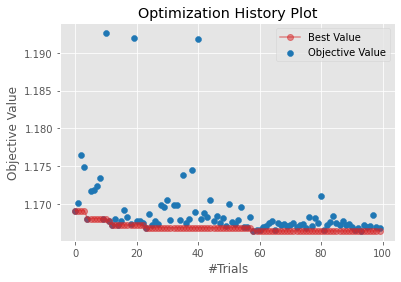

In [63]:
# Visualise the errors obtained throughout the trials
optuna.visualization.matplotlib.plot_optimization_history(study1)

<ipython-input-64-f28880b3a62b>:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study1)


array([<AxesSubplot:xlabel='colsample_bytree', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='gamma'>, <AxesSubplot:xlabel='learning_rate'>,
       <AxesSubplot:xlabel='max_depth'>,
       <AxesSubplot:xlabel='min_child_weight'>,
       <AxesSubplot:xlabel='reg_alpha'>,
       <AxesSubplot:xlabel='reg_lambda'>,
       <AxesSubplot:xlabel='subsample'>], dtype=object)

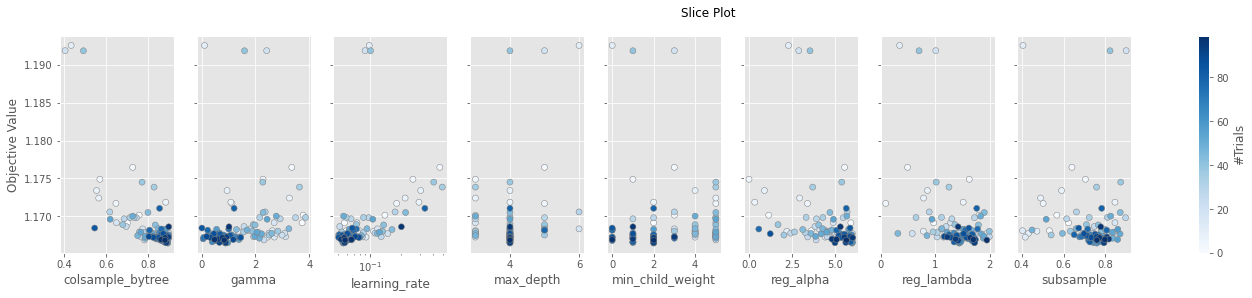

In [64]:
# Visualise the errors obtained with every combination of hyperparameters
optuna.visualization.matplotlib.plot_slice(study1)

In [65]:
# Train XGBoost with the best hyperparameters found from the study
best_model = xgb.train(study1.best_params , dtrain, num_boost_round = 10000, evals = [(dval, 'eval')],
          early_stopping_rounds=100,verbose_eval = 0)

In [66]:
# Predict the score of each review using the XGBoost with hyperparameters tuning
pred = best_model.predict(dtest)
pred

array([9.521817, 9.090833, 8.580285, ..., 9.455518, 7.796848, 9.411437],
      dtype=float32)

In [67]:
# Calculate RMSE score on the test dataset
result = best_model.eval(dtest)
result

'[0]\teval-rmse:1.166685'

In [69]:
# Calculate R2 score (this tells us how well the regression fits the data)
r2 = r2_score(y_test, pred)
r2

0.49395503768916527

**Let's compare the violin plot results between with and without tuning.**

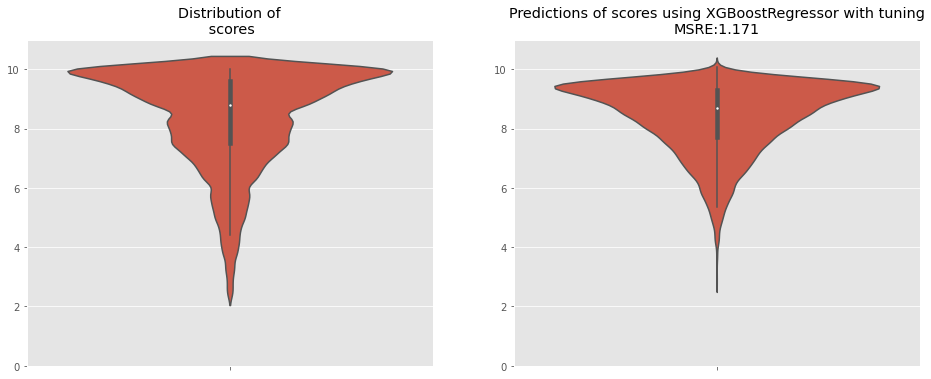

In [68]:
plot_res(y_test,pred, model = "XGBoostRegressor with tuning")

In [75]:
default_model = xgb.train(params={}, dtrain=dtrain, num_boost_round = 10000, evals = [(dval, 'eval')],
          early_stopping_rounds=100,verbose_eval = 0)
pred_default = default_model.predict(dtest)
pred_default

array([9.465464 , 9.114336 , 8.6822815, ..., 9.444635 , 7.674981 ,
       9.442249 ], dtype=float32)

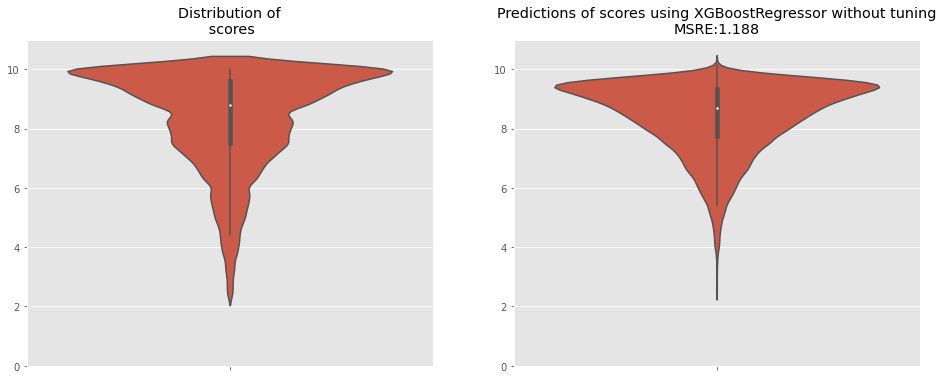

In [76]:
plot_res(y_test,pred_default, model = "XGBoostRegressor without tuning")

Turns out that hyperparameters tuning did not help too much with reducing the errors in our XGBoost model.
Additionaly, XGBoost with hyperparameters tuning gives us almost the same result than GradientBoostingRegressor model i.e. RMSE=1.171 vs RMSE=1.174 respectively.

# Conclusion and Future Work

- We showed some EDA and observed some interesting trends
- We observed from our correlation chart that sentiment values, number of words and average score of hotel are important for training our model.
- After comparing the different models, although XGBoost with hyperparameter tuning may give us the lowest RMSE, the result is almost the same as using GradientBoostingRegressor model, which is simpler to implement.
- Our XGBoost model with hyperparameters tuning gave us a regression line that fits the actual data about 49% well.

Future Improvements:
- Sentiment analyser could be improved as negative review like
	“walls are pretty thin so could hear folk in their bathroom and in the corridor”
    gives sentiment score of {'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'compound': 0.4939}. This points out that there is a major flaw in our models.
- Best solution is to build our own sentiment analyser for specific context such as in this hotel reviews dataset.
- Look at specific word mentioned in reviews (e.g. airconditioner, room, staff) and hot-encode them to see if they have high correlation with reviewer score